Dans ce notebook, nous allons utiliser quelques modèles de machine learning dans le but de prédire nos deux variables cibles, **SiteEnergyUse(kBtu)** et **TotalGHGEmissions**, grâce au *feature engineering* réalisé dans le notebook de nettoyage précédent.

Dans un second temps, on cherchera à évaluer l’intérêt de l’**ENERGY STAR Score** pour la prédiction. Pour ce faire, on va intégrer cette variable comme nouvelle variable indépendante de notre modélisation et observer son effet sur les métriques de performances. On verra que le score des modèles ensemblistes devient nettement meilleur lorsque l'on tient compte de cette variable.



# <font color="#00afe6">Sommaire</font>
1. [Préparation de la modélisation](#section_1)     
2. [Modèle Baseline](#section_2)        
3. [Modélisation sans l'ESS](#section_3)        
    3.1 [Méthodes de régréssion](#section_3_1)        
    3.2 [Méthodes ensemblistes](#section_3_2)        
    3.3 [Performances](#section_3_3)        
4. [Évaluation de l'ESS](#section_4)            

In [1]:
# Importation des librairies Python

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', '{:.3g}'.format)


import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 20
font_style = {'weight': 'bold',
              'size': 20}

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")

import time

In [2]:
df = pd.read_csv('datas_cleaned_final.csv', index_col=0)

df.rename(columns = {'SiteEnergyUse(kBtu)':'SiteEnergyUse'}, inplace = True)

df.shape

(1650, 16)

In [3]:
df.isnull().sum()

OSEBuildingID                 0
PrimaryPropertyType           0
PropertyGFATotal              0
LargestPropertyUseType        0
ENERGYSTARScore             551
SiteEnergyUse                 0
TotalGHGEmissions             0
BuildingAge                   0
NewPropertyUseTypes           0
cluster_label                 0
GFALargestRateProp            0
GFALargestRateBuild           0
GFALargestRatePark            0
GFAUseCountRateLargest        0
GFAnbBuildingRateLargest      0
GFAFloorRateLargest           0
dtype: int64

In [4]:
var_target = ['SiteEnergyUse',
              'TotalGHGEmissions']

# <font color="#00afe6" id=section_1>1. Préparation de la modélisation. </font>

Comme nous l'avons vu dans le notebook précédent, la distribution des variables quantitatives que nous avons retenues sont très asymétriques. Nous allons donc appliquer une transformation logarithmique uniquement aux *targets* pour avoir des distributions symétriques. Ci-dessous, la distribution originale ainsi que la transformation logarithmique correspondante.

In [5]:
def plot_transform_variables(df,targgPLOT): 
    
    # Variable originale
    y_orig = df[targgPLOT]  
    
    # On utilise la fonction log(1+x) car il exite des zéros dans les variables cibles
    y_log  = df[targgPLOT].apply(lambda x: np.log(x+1))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.histplot(data=y_orig, 
                 ax=axes[0])
    axes[0].set_title("Données initiales", fontdict=font_style)
    axes[0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    axes[0].set_xlabel(targgPLOT, fontdict=font_style)
    axes[0].set_ylabel('Total', fontdict=font_style)
   
    sns.histplot(data=y_log, 
                 ax=axes[1])
    axes[1].set_title("Application du logarithme", fontdict=font_style)
    axes[1].set_xlabel('Log(1+'+targgPLOT+')', fontdict=font_style)
    axes[1].set_ylabel('Total', fontdict=font_style)
    plt.show()

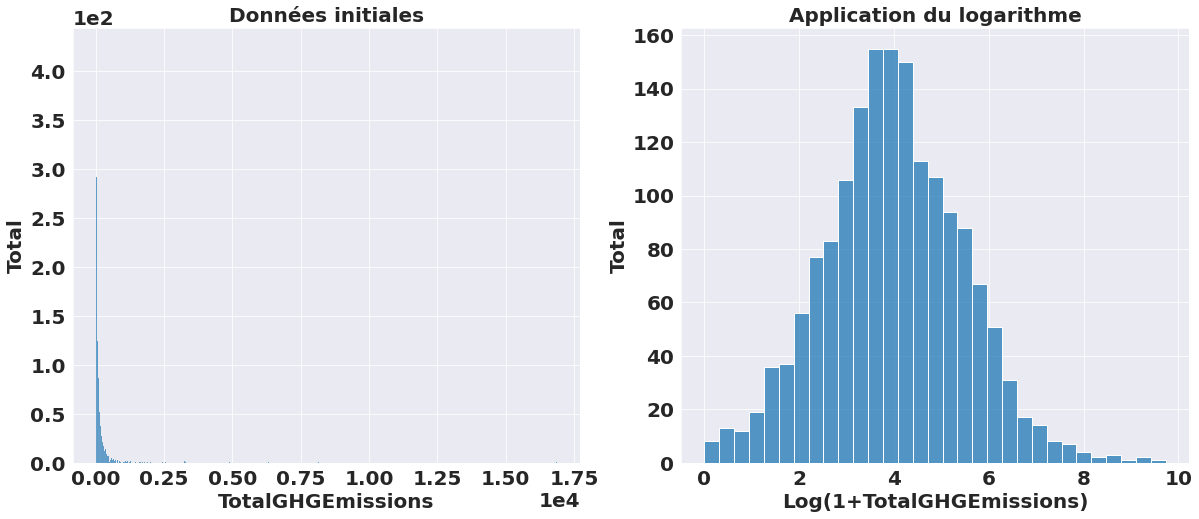

In [6]:
plot_transform_variables(df,'TotalGHGEmissions')

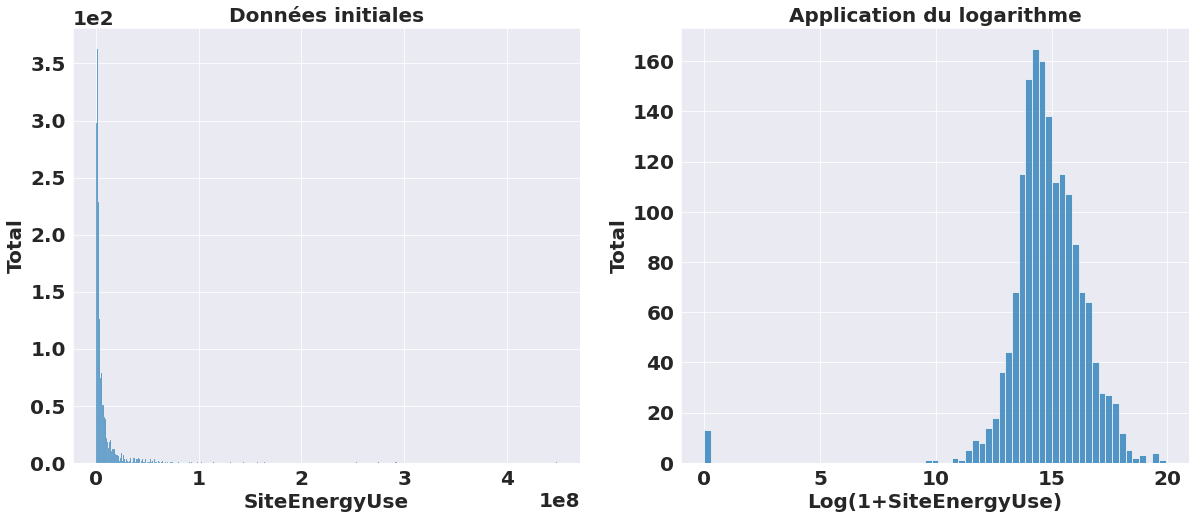

In [7]:
plot_transform_variables(df,'SiteEnergyUse')

On voit que la transformation logarithmique améliore effectivement la symétrie des distributions. 
Dans la suite de ce notebook, nous allons donc utiliser la variable transformée comme *target* à l'aide de *transformer* de la librairie *sklearn*.

### Préparation des jeux d'entraînement et de test.

In [8]:
# Dans un premier temps, on n'inclut pas la variable 'ENERGUSTARScore' parmi les variables numériques
num_var = ['PropertyGFATotal',
           'GFALargestRateProp',
           'GFALargestRatePark',
           'GFALargestRateBuild', 
           'GFAUseCountRateLargest',
           'GFAnbBuildingRateLargest', 
           'GFAFloorRateLargest', 
          ]

cat_var = ['LargestPropertyUseType',
           'PrimaryPropertyType',
           'NewPropertyUseTypes',
           'BuildingAge',
           'cluster_label'
          ]

Dans tout ce notebook, on utilisera le suffixe `_spl` lorsque la variable `ENERGYSTARScore` est absente, et le suffixe `_ess` dans le cas inverse.

In [9]:
# Variables indépendantes
X_spl = df[num_var + cat_var] 

# Variables Cibles
y_spl = df[var_target]

from sklearn.model_selection import train_test_split
X_train_spl, X_test_spl, y_train_spl, y_test_spl = train_test_split(X_spl, 
                                                                    y_spl, 
                                                                    test_size    = 0.25, 
                                                                    random_state = 0)
#
SEU_train_spl = y_train_spl[var_target[0]]
SEU_test_spl  = y_test_spl[var_target[0]]
#
GHG_train_spl = y_train_spl[var_target[1]]
GHG_test_spl  = y_test_spl[var_target[1]]

### Préparation du préprocesseur

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from category_encoders.target_encoder import TargetEncoder

num_transf = StandardScaler()
cat_transf = TargetEncoder()

preprocessor = ColumnTransformer(transformers=[
                                    ('num', num_transf, num_var),
                                    ('cat', cat_transf, cat_var),
                                               ])

### Choix des métriques

On utilisera les fonctions ci-dessous pour comparer les performances des différents modèles.             
Dans un premier temps, dans le but de mesurer l'effet des valeurs isolées (ou outliers) on utilisera les

   1. Mean Absolute Error (sensible aux outliers)        
   2. Median Absolute Error (insensible aux outliers)      
   3. Root Mean Squared Error (sensible aux outliers)    
    
qui donnent des amplitudes dans la même unité que celle des variables à prédire.            
Une fois le meilleur modèle identifié, on utilisera le coefficient de détermination 

   1. R² 
   2. explained variance
    
pour avoir une meilleure idée de la variance captée par le modèle.    

In [11]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

def model_metrics(all_list_true_pred_name):
    df_metrics = pd.DataFrame(index=["Mean AE", "Median AE", "RMSE"])
    #
    for list_true_pred_name in all_list_true_pred_name:
        y_true = list_true_pred_name[0]
        y_pred = list_true_pred_name[1]
        y_name = list_true_pred_name[2]
        #
        meanAE  = mean_absolute_error(y_true,y_pred)
        medAE   = median_absolute_error(y_true,y_pred)
        rmse    = np.sqrt(mean_squared_error(y_true,y_pred))
        #
        df_metrics[y_name] = [meanAE, medAE, rmse]
    return df_metrics


from sklearn.metrics import explained_variance_score, r2_score

def model_variance(all_list_true_pred_name):
    df_metrics = pd.DataFrame(index=["r2score", "expl_variance"])
    #
    for list_true_pred_name in all_list_true_pred_name:
        y_true = list_true_pred_name[0]
        y_pred = list_true_pred_name[1]
        y_name = list_true_pred_name[2]
        #
        r2score  = r2_score(y_true,y_pred)
        exp_var  = explained_variance_score(y_true,y_pred)
        #
        df_metrics[y_name] = [r2score, exp_var]
    return df_metrics

### Préparation des constructeurs : Pipeline &  GridSearch

Lors de l'entrainement du modèle, il est important que toutes les opérations de transformation de la **Pipeline**  (et donc du **preprocesseur**) se déroulent une fois le découpage pour la **cross-validation** effectuée.

In [12]:
from sklearn.pipeline import Pipeline
# Fonction pour créer une pipeline
#
def pipeline_construction(preprocessor, tf_regressor):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', TransformedTargetRegressor(regressor=tf_regressor,
                                                                     func=np.log1p,
                                                                     inverse_func=np.expm1)
                                )]
                        ,verbose=0)
    return pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold 
#GridSearch Cross-Validation
#
def gridsearch_construction(pipeline, params, NbCV):
    seed = 13
    kfold = KFold(n_splits=NbCV, shuffle=True, random_state=seed)
    return GridSearchCV(estimator  = pipeline,
                        param_grid = params,
                        scoring=('r2',
                                 #'neg_mean_absolute_error',
                                 'neg_root_mean_squared_error'),
                        refit='r2',
                        return_train_score = True,
                        cv         = kfold,
                        n_jobs     = -1,
                        verbose    = 1,
                        error_score='raise')

# <font color="#00afe6" id=section_2>2. Modèle baseline. </font>

Comme modèle de base, nous allons considérer la classe `DummyRegressor` de **sklearn**. 

D'après les histogrammes ci-dessous, on voit qu'il est plus intéressant de choisir comme prédiction systématique la médianne plutôt que la moyenne.

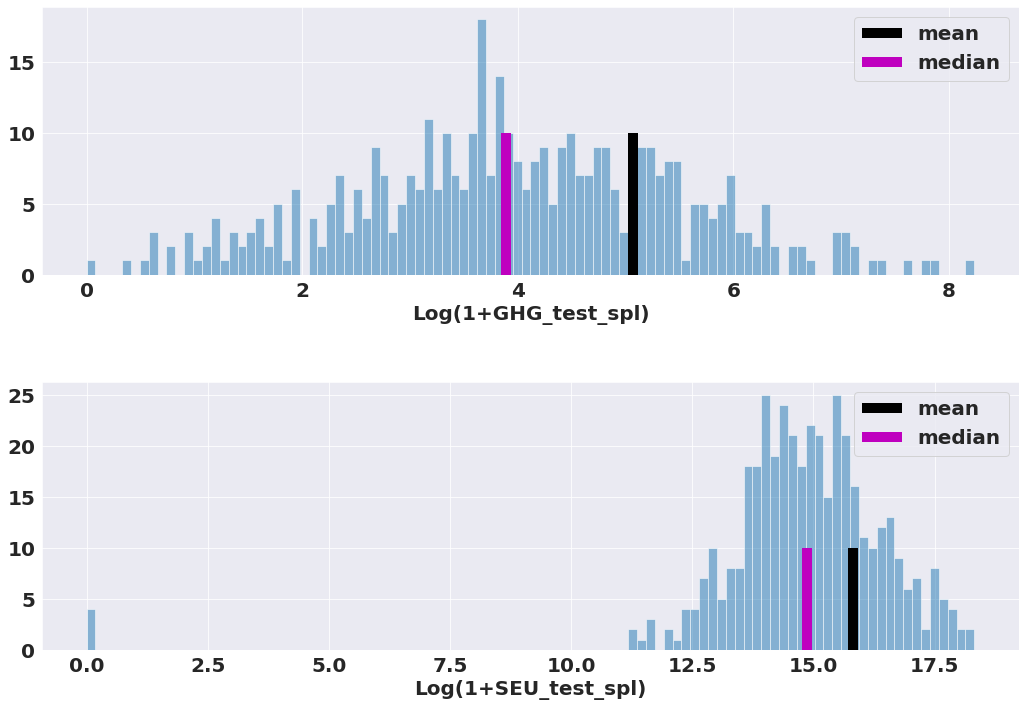

In [14]:
bbins = 100
fig, axs = plt.subplots(2,figsize=(15,10))
fig.tight_layout()
plt.subplots_adjust(hspace=0.4)

axs[0].hist(np.log1p(GHG_test_spl),bins=bbins,alpha=0.5)
axs[0].vlines(x=np.log1p(np.mean(GHG_test_spl)), 
              ymin=0,ymax=10, 
              linewidth=10,color='k', 
              label='mean'),
axs[0].vlines(x=np.log1p(np.median(GHG_test_spl)), 
              ymin=0,ymax=10, 
              linewidth=10,color='m', 
              label='median'),
axs[0].set_xlabel('Log(1+GHG_test_spl)', fontdict=font_style)
axs[0].legend()
#
#
axs[1].hist(np.log1p(SEU_test_spl),bins=bbins,alpha=0.5)
axs[1].vlines(x=np.log1p(np.mean(SEU_test_spl)), 
              ymin=0, ymax=10, 
              linewidth=10, color='k', 
              label='mean'),
axs[1].vlines(x=np.log1p(np.median(SEU_test_spl)), 
              ymin=0,ymax=10, 
              linewidth=10,color='m', 
              label='median'),
axs[1].set_xlabel('Log(1+SEU_test_spl)', fontdict=font_style)
axs[1].legend()
plt.show()
fig.savefig('distrib_empirique.png', bbox_inches='tight')

In [15]:
from sklearn.dummy import DummyRegressor
# 
pipeline_dum = pipeline_construction(preprocessor, DummyRegressor())

# 
grid_params_dum = {"model__regressor__strategy": ['median']}

# 
seu_dum_spl = gridsearch_construction(pipeline_dum, grid_params_dum, 5)
ghg_dum_spl = gridsearch_construction(pipeline_dum, grid_params_dum, 5)

# Entrainement
#
seu_dum_spl.fit(X_train_spl, SEU_train_spl)
display(seu_dum_spl.best_params_)
#
ghg_dum_spl.fit(X_train_spl, GHG_train_spl)
display(ghg_dum_spl.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'model__regressor__strategy': 'median'}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'model__regressor__strategy': 'median'}

In [16]:
# Prédiction sur le test 
SEU_dum_test_spl = seu_dum_spl.predict(X_test_spl)

# Score sur test
SEU_dum_score_spl   = model_metrics([[SEU_test_spl, SEU_dum_test_spl,'SEU_DUM_spl']])

# comparaison avec la baseline
SEU_metrics_spl = SEU_dum_score_spl
SEU_metrics_spl

,SEU_DUM_spl
Mean AE,6.18e+06
Median AE,1.89e+06
RMSE,1.32e+07


In [17]:
# Prédiction sur test
GHG_dum_test_spl = ghg_dum_spl.predict(X_test_spl)

# Score sur test
GHG_dum_score_spl   = model_metrics([[GHG_test_spl, GHG_dum_test_spl, 'GHG_DUM_spl']])

# comparaison avec la baseline
GHG_metrics_spl = GHG_dum_score_spl
GHG_metrics_spl

,GHG_DUM_spl
Mean AE,137
Median AE,40.1
RMSE,359


# <font color="#00afe6" id=section_3>3. Modélisation sans la variable ESS. </font>

# <font color="#00afe6" id=section_3_1>3.1 Méthodes de régression </font>

## Régression linéaire multiple

In [18]:
from sklearn.linear_model import LinearRegression
# 
pipeline_mlr = pipeline_construction(preprocessor,LinearRegression())

# 
grid_params_mlr = {"model__regressor__fit_intercept": [True, False]}

# 
seu_mlr_spl = gridsearch_construction(pipeline_mlr, grid_params_mlr,5)
ghg_mlr_spl = gridsearch_construction(pipeline_mlr, grid_params_mlr,5)

# Entrainement
#
seu_mlr_spl.fit(X_train_spl, SEU_train_spl)
display(seu_mlr_spl.best_params_)
#
ghg_mlr_spl.fit(X_train_spl, GHG_train_spl)
display(ghg_mlr_spl.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'model__regressor__fit_intercept': True}

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'model__regressor__fit_intercept': True}

In [19]:
# Prédiction sur le test set
SEU_mlr_test_spl = seu_mlr_spl.predict(X_test_spl)

# Score sur test set
SEU_mlr_score_spl  = model_metrics([[SEU_test_spl, SEU_mlr_test_spl, 'SEU_MLR_spl']])

# comparaison avec la baseline
SEU_metrics_spl = pd.concat([SEU_metrics_spl, SEU_mlr_score_spl], axis=1)
SEU_metrics_spl

,SEU_DUM_spl,SEU_MLR_spl
Mean AE,6.18e+06,5.23e+06
Median AE,1.89e+06,1.36e+06
RMSE,1.32e+07,1.48e+07


In [20]:
# Prédiction sur test set
GHG_mlr_test_spl = ghg_mlr_spl.predict(X_test_spl)

# Score sur test set
GHG_mlr_score_spl   = model_metrics([[GHG_test_spl, GHG_mlr_test_spl, 'GHG_MLR_spl']])

# comparaison avec la baseline
GHG_metrics_spl = pd.concat([GHG_metrics_spl, GHG_mlr_score_spl], axis=1)
GHG_metrics_spl

,GHG_DUM_spl,GHG_MLR_spl
Mean AE,137,125
Median AE,40.1,31.8
RMSE,359,335


## Modèle de régression avec régularisation L1 & L2 : Elastic Net

In [21]:
from sklearn.linear_model import ElasticNet

# 
pipeline_net = pipeline_construction(preprocessor,ElasticNet())
#
grid_params_net = {"model__regressor__alpha": np.logspace(-5, 3, 20), 
                   "model__regressor__l1_ratio": np.logspace(-2, 0, 10),
                   #"model__regressor__tol": [0.00001]
                  }

###########
start_time = time.time()
# 
ghg_net_spl = gridsearch_construction(pipeline_net, grid_params_net, 5)
seu_net_spl = gridsearch_construction(pipeline_net, grid_params_net, 5)

# Entrainement
#
seu_net_spl.fit(X_train_spl, SEU_train_spl)
display(seu_net_spl.best_params_)
print("Temps d'execution pour SEU : {:.3} s.".format((time.time() - start_time)))
###########
start_time = time.time()
#
ghg_net_spl.fit(X_train_spl, GHG_train_spl)
display(ghg_net_spl.best_params_)
print("Temps d'execution pour GHG : {:.3} s.".format((time.time() - start_time)))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'model__regressor__alpha': 1.1288378916846884,
 'model__regressor__l1_ratio': 0.21544346900318834}

Temps d'execution pour SEU : 17.6 s.
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'model__regressor__alpha': 54.555947811685144,
 'model__regressor__l1_ratio': 0.5994842503189409}

Temps d'execution pour GHG : 17.4 s.


In [22]:
# Prédiction sur le test  set
SEU_net_test_spl = seu_net_spl.predict(X_test_spl)

# Score sur test set
SEU_net_score_spl   = model_metrics([[SEU_test_spl, SEU_net_test_spl, 'SEU_NET_spl']])

# comparaison avec la baseline
SEU_metrics_spl = pd.concat([SEU_metrics_spl, SEU_net_score_spl], axis=1)
SEU_metrics_spl

,SEU_DUM_spl,SEU_MLR_spl,SEU_NET_spl
Mean AE,6.18e+06,5.23e+06,5.52e+06
Median AE,1.89e+06,1.36e+06,1.66e+06
RMSE,1.32e+07,1.48e+07,1.21e+07


In [23]:
# Prédiction sur test set
GHG_net_test_spl = ghg_net_spl.predict(X_test_spl)

# Score sur test set
GHG_net_score_spl   = model_metrics([[GHG_test_spl, GHG_net_test_spl, 'GHG_NET_spl']])

# comparaison avec la baseline
GHG_metrics_spl = pd.concat([GHG_metrics_spl, GHG_net_score_spl], axis=1)
GHG_metrics_spl

,GHG_DUM_spl,GHG_MLR_spl,GHG_NET_spl
Mean AE,137,125,135
Median AE,40.1,31.8,38.2
RMSE,359,335,356


On peut conclure que les deux modèles de régression testés ci-dessus sont comparables et ne sont que légèrement meilleurs comparé au modèle baseline, qui prédit systématiquement la valeur médiane.

### Coefficients des modèles de régression

In [24]:
# Régression linéaire multiple
coeffs_seu_mlr_spl = pd.DataFrame(
    seu_mlr_spl.best_estimator_.named_steps.model.regressor_.coef_,
    columns=["SEU_mlr_spl"],
    index=X_train_spl.columns,
)

coeffs_ghg_mlr_spl = pd.DataFrame(
    ghg_mlr_spl.best_estimator_.named_steps.model.regressor_.coef_,
    columns=["GHG_mlr_spl"],
    index=X_train_spl.columns,
)

# Elastic Net
coeffs_seu_net_spl = pd.DataFrame(
    seu_net_spl.best_estimator_.named_steps.model.regressor_.coef_,
    columns=["SEU_net_spl"],
    index=X_train_spl.columns,
)

coeffs_ghg_net_spl = pd.DataFrame(
    ghg_net_spl.best_estimator_.named_steps.model.regressor_.coef_,
    columns=["GHG_net_spl"],
    index=X_train_spl.columns,
)

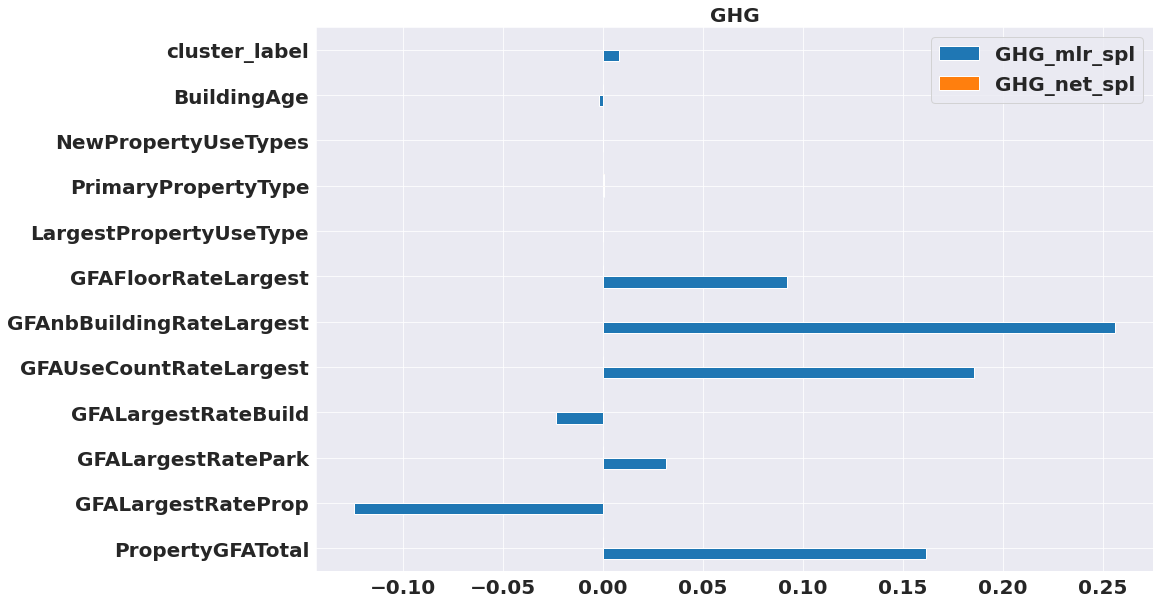

In [25]:
pd.concat([coeffs_ghg_mlr_spl, coeffs_ghg_net_spl],axis=1).plot.barh(figsize=(15,10))
plt.title('GHG', fontdict=font_style)
plt.show()

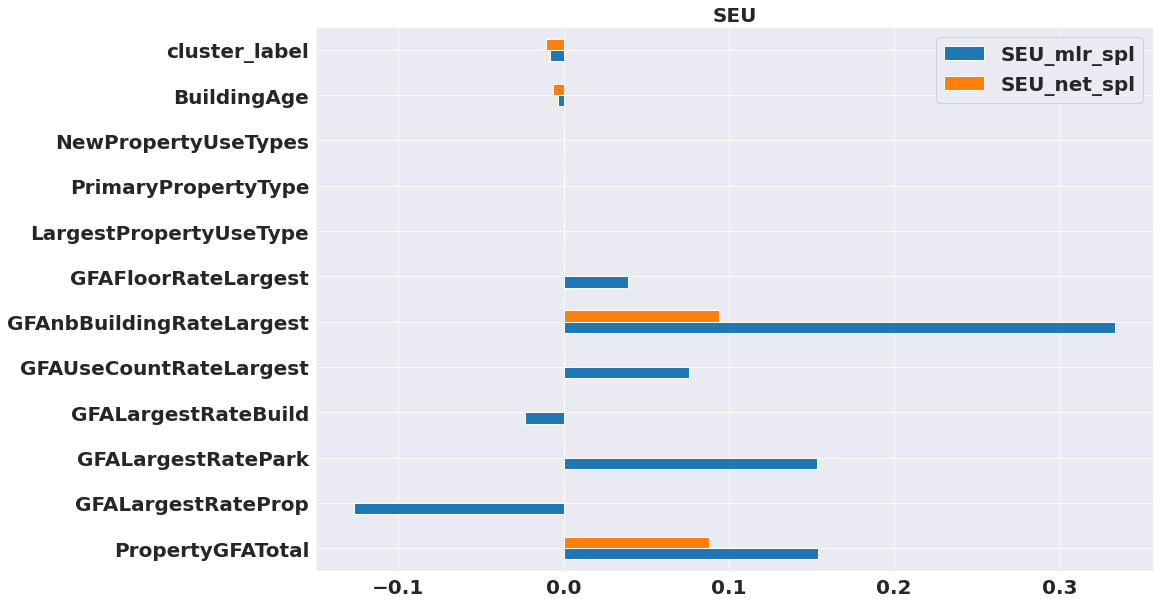

In [26]:
pd.concat([coeffs_seu_mlr_spl, coeffs_seu_net_spl],axis=1).plot.barh(figsize=(15,10))
plt.title('SEU', fontdict=font_style)
plt.show()

On peut voir que les deux modèles de régression pénalisent les variables catégorielles pour la prédiction des *targets*. 
D'autre part, la réduction des estimateurs des variables quantitatives par le régresseur `ElasticNet` ne résulte pas en une meilleure performance. Ce qui a pour conséquence une légère augmentation des erreurs moyenne et médiane. Les performances restent néanmoins semblables au modèle baseline.

# <font color="#00afe6" id=section_3_2>3.2 Méthodes ensemblistes </font>

In [27]:
# Fonction pour tracer les résultats de la GridSearch pour 4 jeux de paramètres

def plot_reduced_grid(grid_dataframe, target , dict_param_st, name_param_dy, metrics, value_param_3):
    
    # Réduction du daframe cv_results pour garder deux paramètres "dynamiques"
    cv_dataframe = pd.DataFrame(grid_dataframe)
    for name, st_param in dict_param_st.items():
        cv_dataframe = cv_dataframe[(cv_dataframe['param_'+name]==st_param)]
        # print(cv_dataframe.shape)
    
    # Paramètres "dynamiques" de la GridSearchCV
    name_param_1 = name_param_dy[0]
    name_param_2 = name_param_dy[1]
    grid_param_1 = cv_dataframe['param_'+ name_param_1].unique()
    grid_param_2 = cv_dataframe['param_'+ name_param_2].unique()
    
    # Score du Train et Test set pour la métrique choisie
    scores_train = cv_dataframe['mean_train_%s' % (str(metrics))]
    scores_train = np.array(scores_train).reshape(len(grid_param_2),len(grid_param_1))

    scores_test = cv_dataframe['mean_test_%s' % (str(metrics))]
    scores_test = np.array(scores_test).reshape(len(grid_param_2),len(grid_param_1))
    
    # Suppression du prefix du dict des params pour l'affichage
    prefix = 'model__regressor__'
    
    # Plot Grid search scores
    fig, ax = plt.subplots(2,figsize=(20,10))
    plt.suptitle("Scores de la GridSearch pour %s avec %s" 
                 % (str(target), str(value_param_3).replace(prefix,'')), 
                 fontsize=20, fontweight='bold')

    with plt.rc_context({"axes.grid": "True", "font.size":20, 'lines.linewidth': 5, 'font.weight': 'bold'}):
        for idx, val in enumerate(grid_param_2):
            ax[0].plot(grid_param_1, scores_train[idx,:], '-o', label= name_param_2 + ': ' + str(val))
            ax[1].plot(grid_param_1, scores_test[idx,:], '-o', label= name_param_2 + ': ' + str(val))

        ax[0].set_ylabel('CV mean train %s' % (str(metrics)), fontsize=20, weight='bold')
        ax[1].set_ylabel('CV mean test %s' % (str(metrics)), fontsize=20, weight='bold')

        plt.xlabel(name_param_1.replace(prefix, ''),fontsize=20, weight='bold')
        handles, labels = ax[1].get_legend_handles_labels()
        labels = map(str, labels)
        labels = map(lambda x: x.replace(prefix, ''), labels)
        fig.legend(handles, labels, loc='upper right')

## RandomForest Regressor

In [28]:
from sklearn.ensemble import RandomForestRegressor

# 
pipeline_rfr = pipeline_construction(preprocessor,RandomForestRegressor())

# 
grid_params_rfr = {'model__regressor__n_estimators'      : [50, 100, 200, 300, 400], 
                   'model__regressor__max_depth'         : [5, 10, 15, 20, 25],
                   'model__regressor__min_samples_leaf'  : [1, 3, 5], # [1], # 
                   'model__regressor__min_samples_split' : [5, 10, 20] # [2] # 
                     }
###########
start_time = time.time()
#
seu_rfr_spl = gridsearch_construction(pipeline_rfr, grid_params_rfr, 5)
ghg_rfr_spl = gridsearch_construction(pipeline_rfr, grid_params_rfr, 5)

# Entrainement
#
seu_rfr_spl.fit(X_train_spl, SEU_train_spl)
display(seu_rfr_spl.best_params_)
print("Temps d'execution pour SEU : {:.3} s.".format((time.time() - start_time)))
###########
start_time = time.time()
# 
ghg_rfr_spl.fit(X_train_spl, GHG_train_spl)
display(ghg_rfr_spl.best_params_)
#
print("Temps d'execution pour GHG : {:.3} s.".format((time.time() - start_time)))

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


{'model__regressor__max_depth': 25,
 'model__regressor__min_samples_leaf': 1,
 'model__regressor__min_samples_split': 5,
 'model__regressor__n_estimators': 50}

Temps d'execution pour SEU : 2e+02 s.
Fitting 5 folds for each of 225 candidates, totalling 1125 fits


{'model__regressor__max_depth': 15,
 'model__regressor__min_samples_leaf': 1,
 'model__regressor__min_samples_split': 5,
 'model__regressor__n_estimators': 50}

Temps d'execution pour GHG : 1.98e+02 s.


In [29]:
# Prédiction sur le test  set
SEU_rfr_test_spl = seu_rfr_spl.predict(X_test_spl)

# Score sur test set
SEU_rfr_score_spl   = model_metrics([[SEU_test_spl, SEU_rfr_test_spl, 'SEU_RFR_spl']])

# comparaison avec la baseline
SEU_metrics_spl = pd.concat([SEU_metrics_spl, SEU_rfr_score_spl], axis=1)
SEU_metrics_spl

,SEU_DUM_spl,SEU_MLR_spl,SEU_NET_spl,SEU_RFR_spl
Mean AE,6.18e+06,5.23e+06,5.52e+06,3.26e+06
Median AE,1.89e+06,1.36e+06,1.66e+06,1.03e+06
RMSE,1.32e+07,1.48e+07,1.21e+07,7.34e+06


In [30]:
# Prédiction sur test set
GHG_rfr_test_spl = ghg_rfr_spl.predict(X_test_spl)

# Score sur test set
GHG_rfr_score_spl   = model_metrics([[GHG_test_spl, GHG_rfr_test_spl, 'GHG_RFR_spl']])

# comparaison avec la baseline
GHG_metrics_spl = pd.concat([GHG_metrics_spl, GHG_rfr_score_spl], axis=1)
GHG_metrics_spl

,GHG_DUM_spl,GHG_MLR_spl,GHG_NET_spl,GHG_RFR_spl
Mean AE,137,125,135,92.3
Median AE,40.1,31.8,38.2,24.4
RMSE,359,335,356,241


Les performances de l'algorithme `RandomForestRegressor` sont nettement meilleures que celles des méthodes de régression. 
Les scores des métriques **Mean AE** et de la **RMSE** (sensibles aux valeurs extrêmes) sont améliorés d'environ 30% pour la prédiction des deux *targets*.


Ci-dessous les évolutions du coefficient de détermination **R²** utilisé lors de l'entrainement dans la gridsearch pour les deux variables cibles. Les scores entre les jeux d'entrainement et de test sont assez proches et démontrent que le modèle ne fait pas de sur-apprentissage.

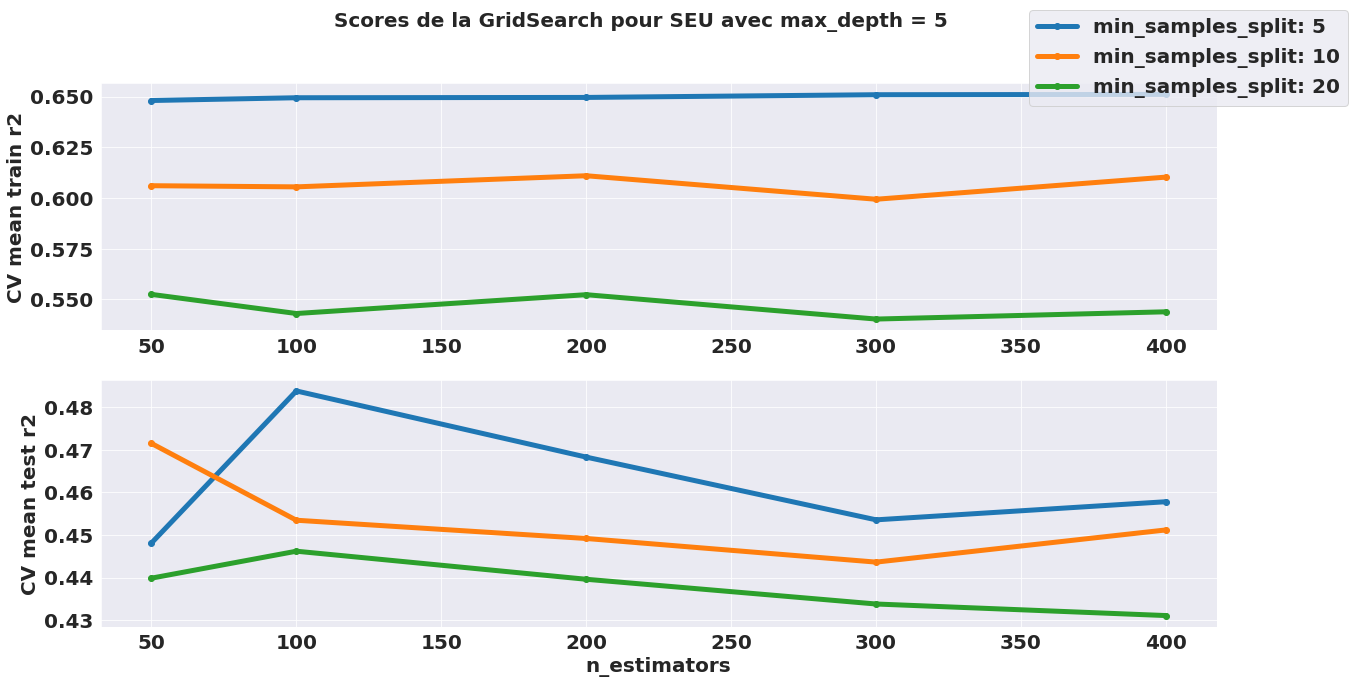

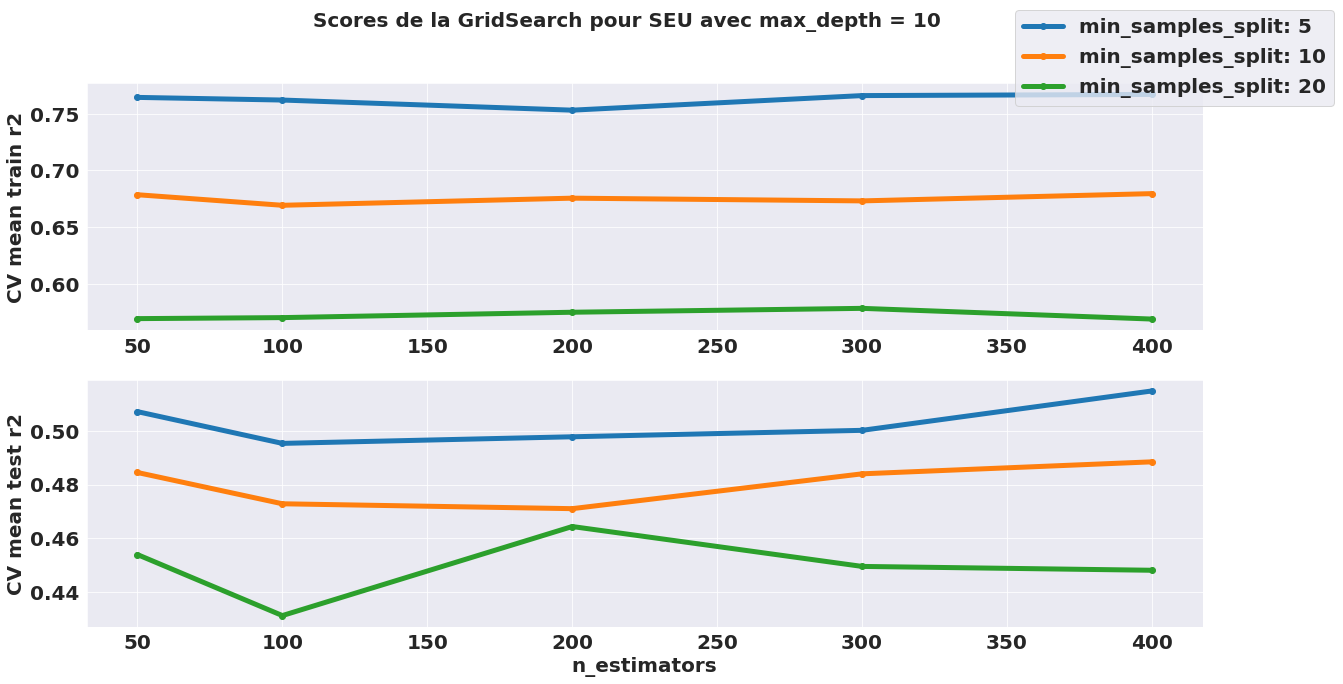

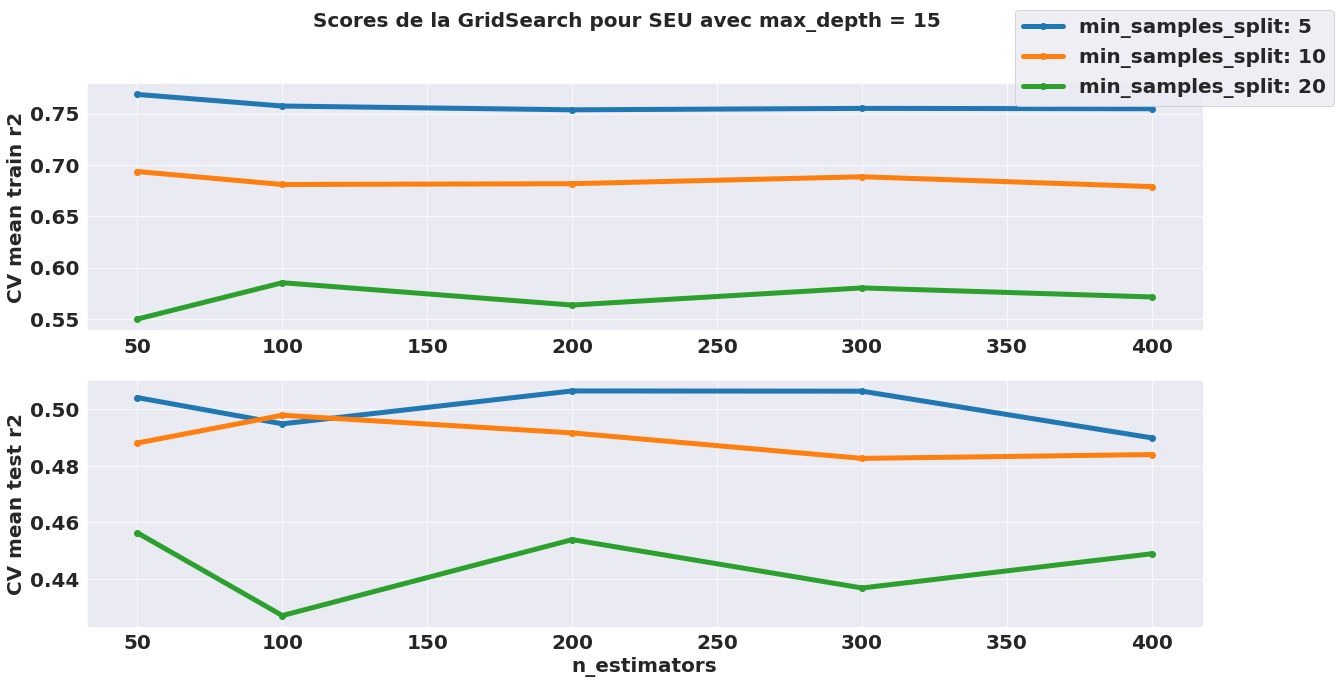

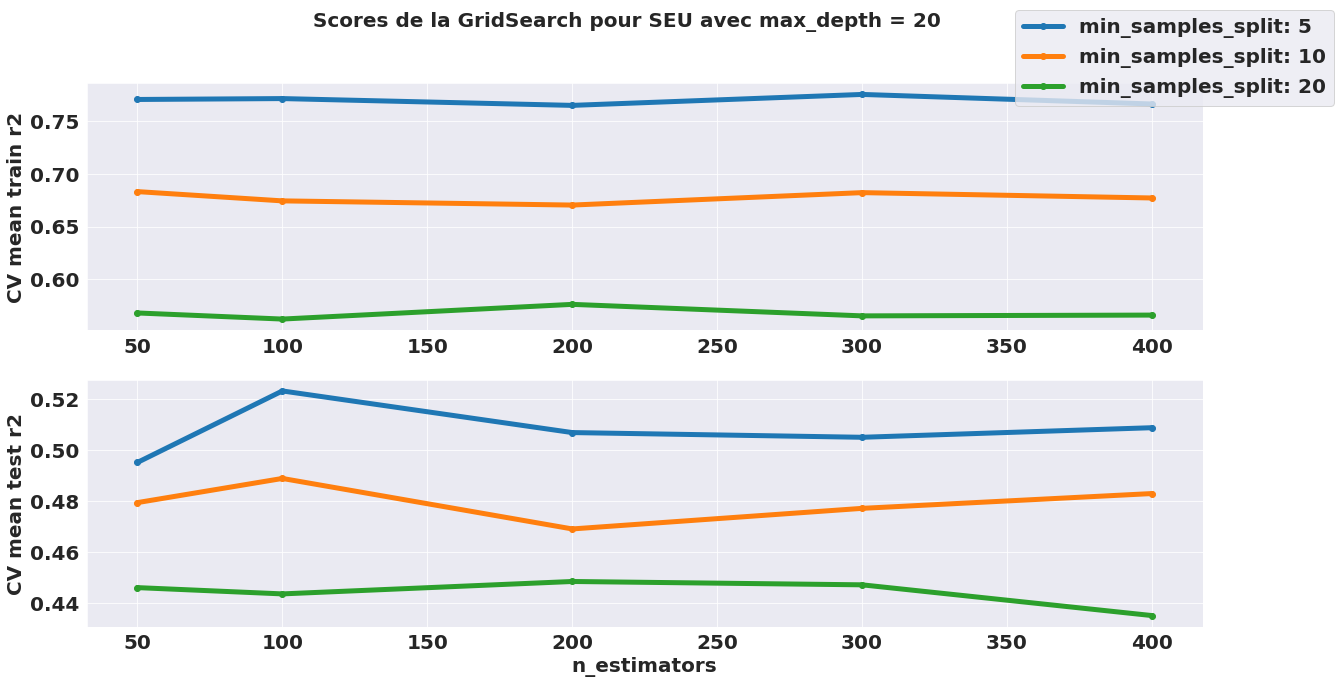

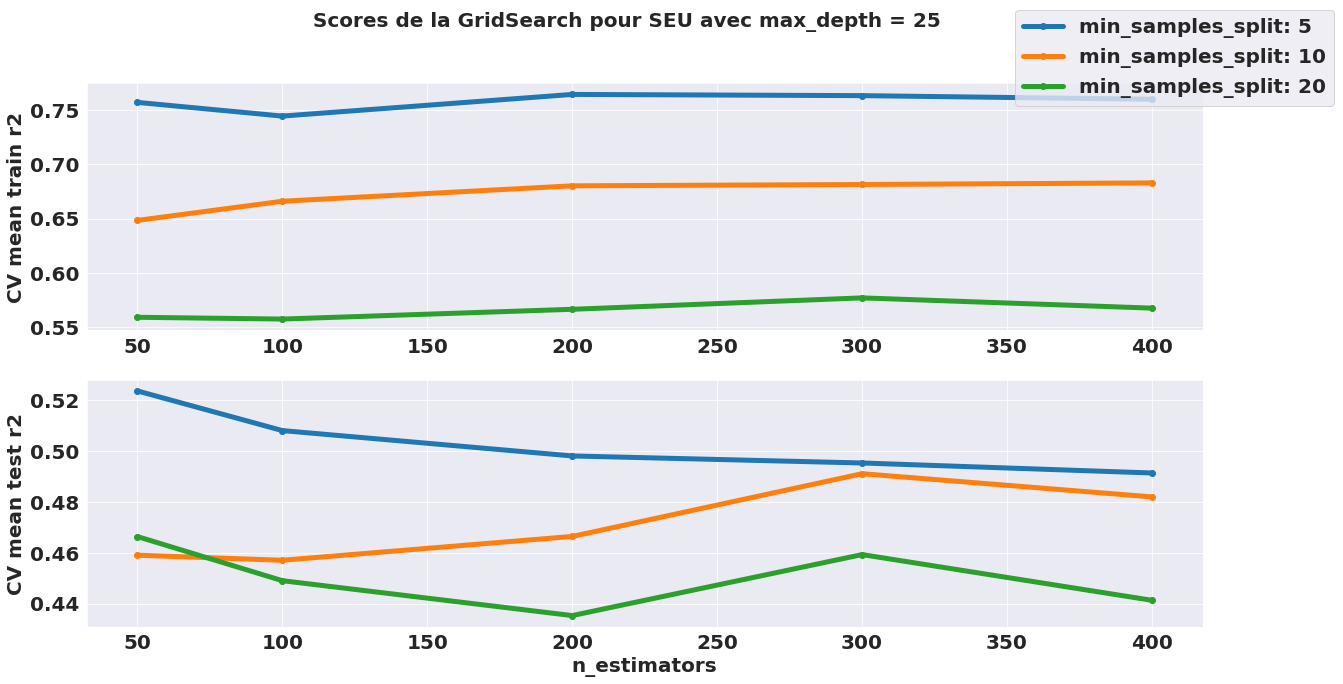

In [31]:
# Liste des paramètres "dynamiques"
name_param_dy = ['model__regressor__n_estimators',
                 'model__regressor__min_samples_split']

for p in np.arange(0,5,):
    # Paramètre "intermédiare"
    s = 'model__regressor__max_depth'
    v = grid_params_rfr[s][p]
    
    # Dictionnaire des paramètres "statiques"
    dict_param_st = {s : v ,
                    'model__regressor__min_samples_leaf' : 1,
                    }
    
    plot_reduced_grid(seu_rfr_spl.cv_results_,
                      'SEU',
                    dict_param_st,
                    name_param_dy,
                    'r2',
                    s + ' = ' + str(v))

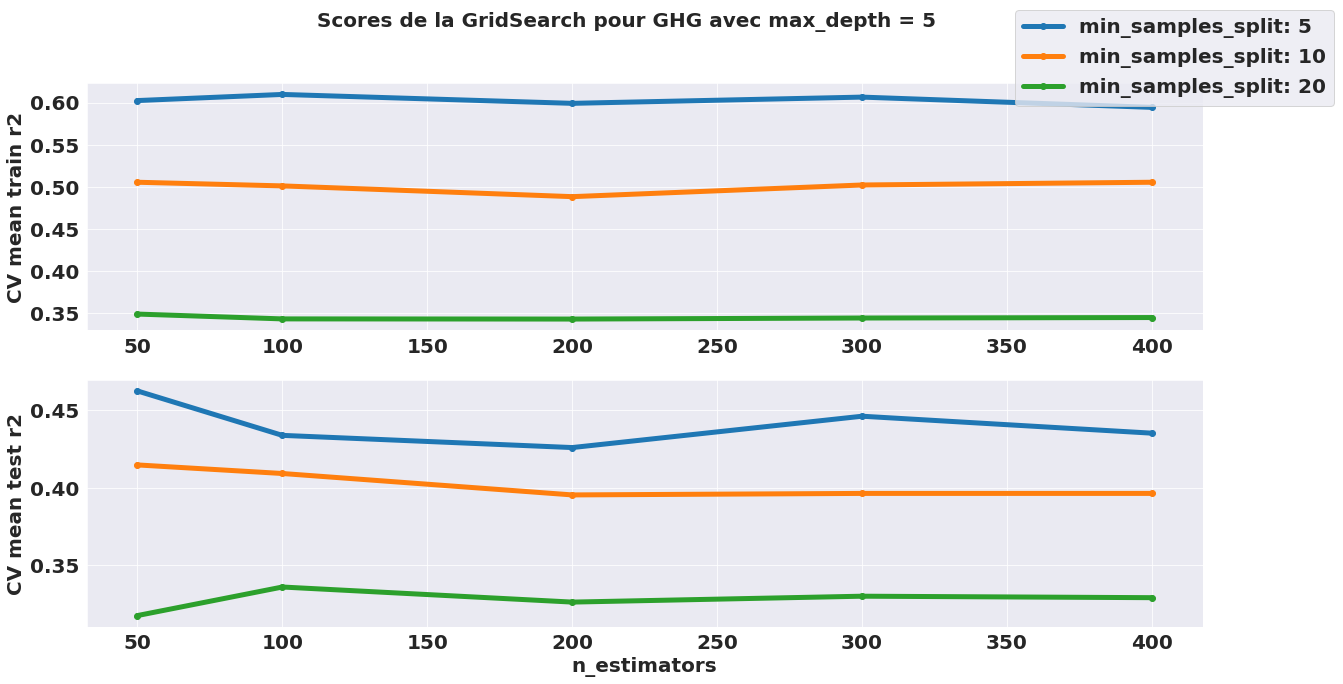

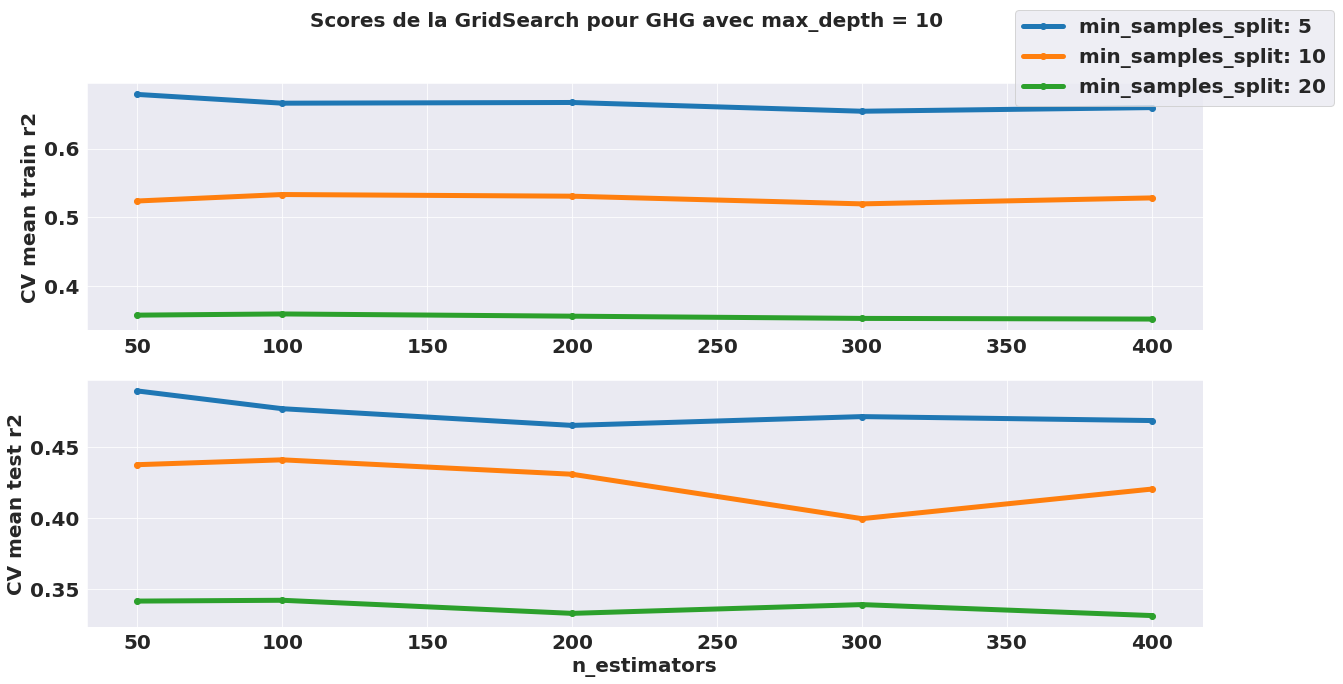

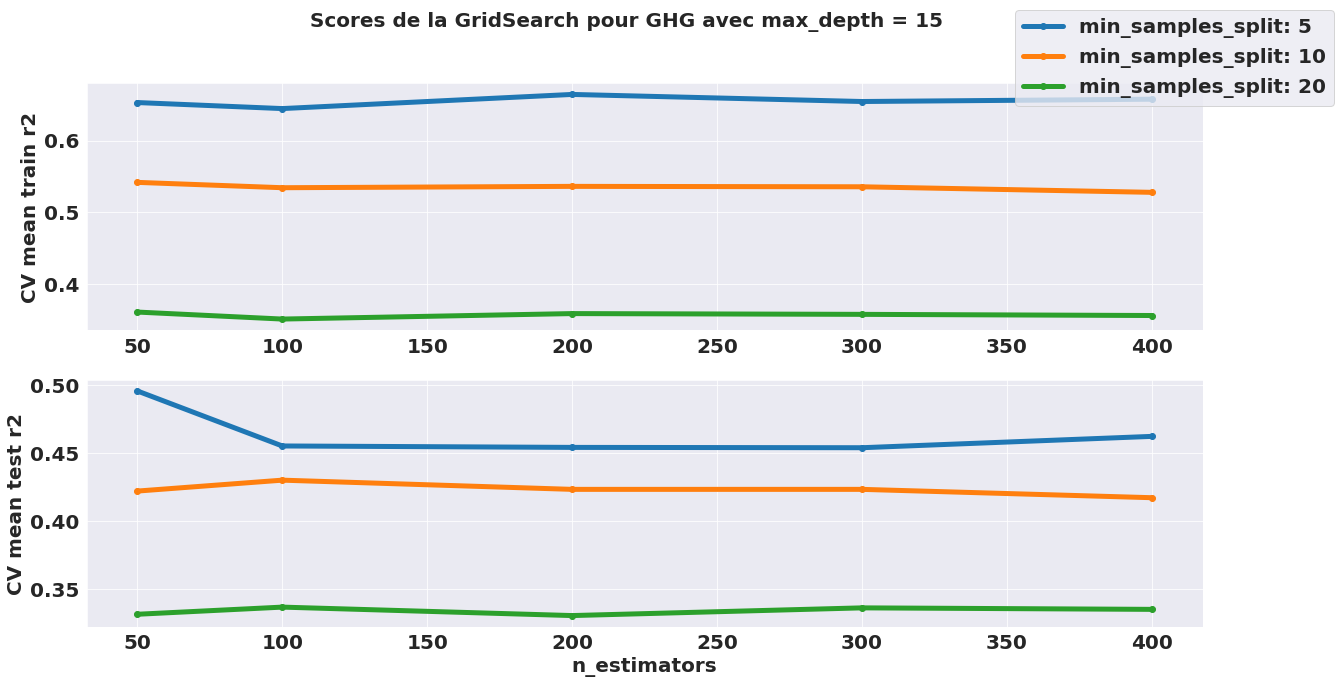

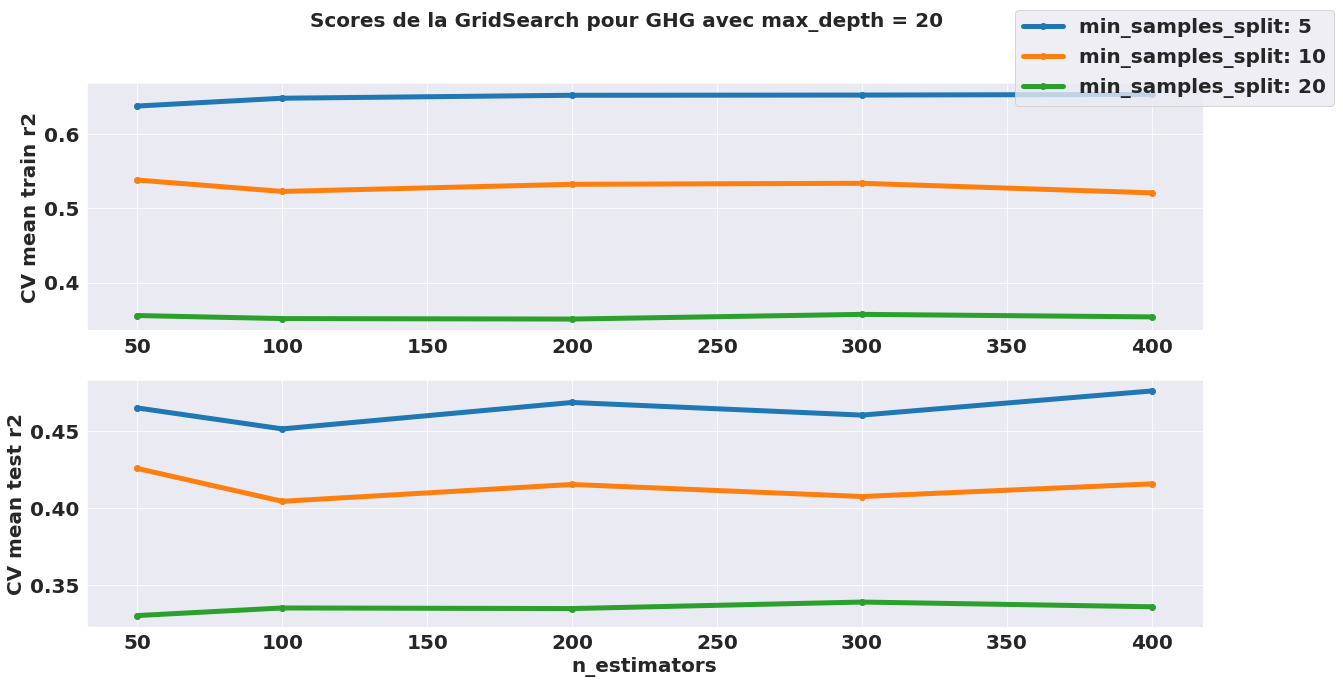

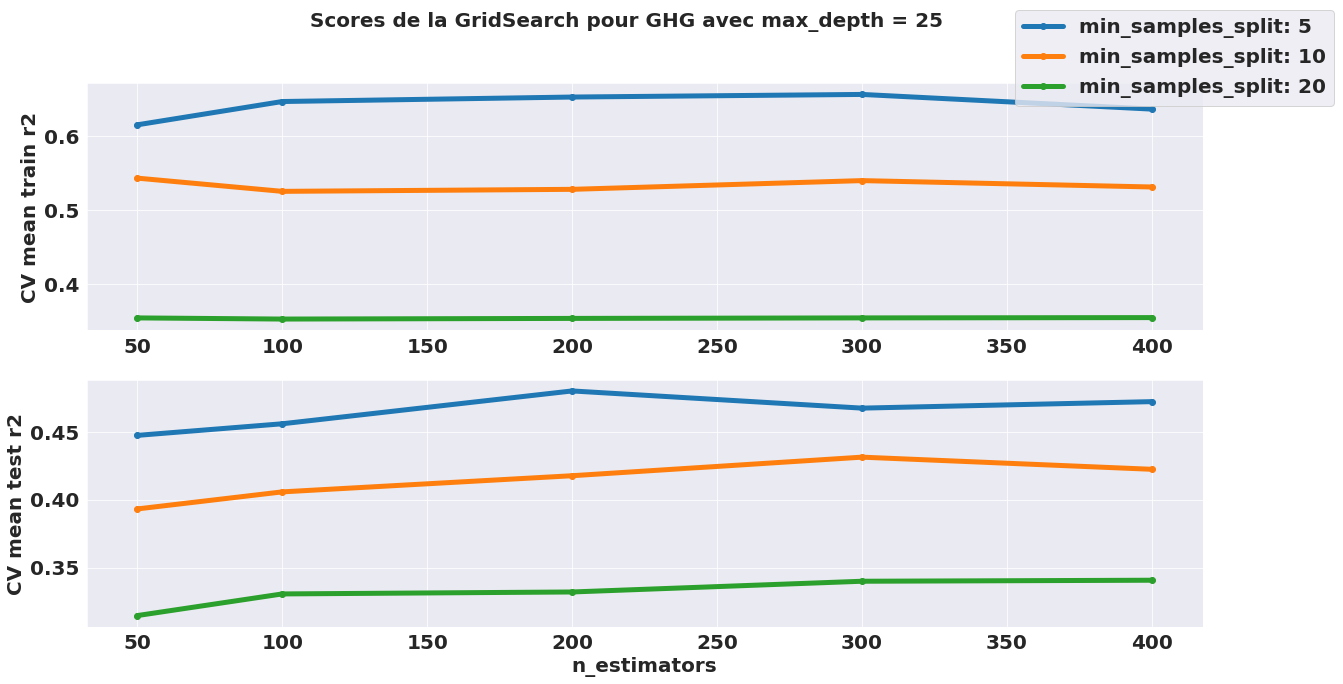

In [32]:
# Liste des paramètres "dynamiques"
name_param_dy = ['model__regressor__n_estimators',
                 'model__regressor__min_samples_split']

for p in np.arange(0,5,):
    # Paramètre "intermédiare"
    s = 'model__regressor__max_depth'
    v = grid_params_rfr[s][p]
    
    # Dictionnaire des paramètres "statiques"
    dict_param_st = {s : v ,
                    'model__regressor__min_samples_leaf' : 1,
                    }
    
    plot_reduced_grid(ghg_rfr_spl.cv_results_,
                      'GHG', 
                    dict_param_st,
                    name_param_dy,
                    'r2',
                    s + ' = ' + str(v))

## Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
# 
pipeline_gbr = pipeline_construction(preprocessor,GradientBoostingRegressor())
#
grid_params_gbr =  {"model__regressor__learning_rate"     : np.linspace(0.1, 0.5, 5), 
                    "model__regressor__max_depth"         : [1, 5, 10, 15, 20], 
                    'model__regressor__min_samples_leaf'  : [1, 5, 10], 
                    'model__regressor__min_samples_split' : [5, 10, 15]
                      }

###########
start_time = time.time()
# 
seu_gbr_spl = gridsearch_construction(pipeline_gbr, grid_params_gbr, 5)
ghg_gbr_spl = gridsearch_construction(pipeline_gbr, grid_params_gbr, 5)

# Entrainement
#
seu_gbr_spl.fit(X_train_spl, SEU_train_spl)
display(seu_gbr_spl.best_params_)
print("Temps d'execution pour SEU : {:.3} s.".format((time.time() - start_time)))
###########
start_time = time.time()
#
ghg_gbr_spl.fit(X_train_spl, GHG_train_spl)
display(ghg_gbr_spl.best_params_)
#
print("Temps d'execution pour GHG : {:.3} s.".format((time.time() - start_time)))

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


{'model__regressor__learning_rate': 0.1,
 'model__regressor__max_depth': 10,
 'model__regressor__min_samples_leaf': 1,
 'model__regressor__min_samples_split': 10}

Temps d'execution pour SEU : 1.29e+02 s.
Fitting 5 folds for each of 225 candidates, totalling 1125 fits


{'model__regressor__learning_rate': 0.4,
 'model__regressor__max_depth': 15,
 'model__regressor__min_samples_leaf': 1,
 'model__regressor__min_samples_split': 15}

Temps d'execution pour GHG : 1.31e+02 s.


In [34]:
# Prédiction sur le test set
SEU_gbr_test_spl = seu_gbr_spl.predict(X_test_spl)

# Score sur test set
SEU_gbr_score_spl = model_metrics([[SEU_test_spl, SEU_gbr_test_spl, 'SEU_GBR_spl']])

# comparaison avec la baseline
SEU_metrics_spl = pd.concat([SEU_metrics_spl, SEU_gbr_score_spl], axis=1)
SEU_metrics_spl

,SEU_DUM_spl,SEU_MLR_spl,SEU_NET_spl,SEU_RFR_spl,SEU_GBR_spl
Mean AE,6.18e+06,5.23e+06,5.52e+06,3.26e+06,3.43e+06
Median AE,1.89e+06,1.36e+06,1.66e+06,1.03e+06,1.15e+06
RMSE,1.32e+07,1.48e+07,1.21e+07,7.34e+06,7.58e+06


In [35]:
# Prédiction sur test set
GHG_gbr_test_spl = ghg_gbr_spl.predict(X_test_spl)

# Score sur test set
GHG_gbr_score_spl   = model_metrics([[GHG_test_spl, GHG_gbr_test_spl, 'GHG_GBR_spl']])

# comparaison avec la baseline
GHG_metrics_spl = pd.concat([GHG_metrics_spl, GHG_gbr_score_spl], axis=1)
GHG_metrics_spl

,GHG_DUM_spl,GHG_MLR_spl,GHG_NET_spl,GHG_RFR_spl,GHG_GBR_spl
Mean AE,137,125,135,92.3,101
Median AE,40.1,31.8,38.2,24.4,28.5
RMSE,359,335,356,241,248


On peut voir que les performances des modèles ensemblistes sont bien meilleures que ceux des modèles de régression avec/sans régularisations selon les trois métriques de référence. À ce stade, sans tenir compte de l'**ESS**, on peut dire que les performances du `RandomForestRegressor` sont les meilleures. 

Ci-dessous, les évolutions des scores de la gridsearch pour le modèle `GradientBoostingRegressor`. Sur les jeux d'entrainement, on remarque que les scores sont bien sensiblement meilleurs que pour le modèle des forêts aléatoires.

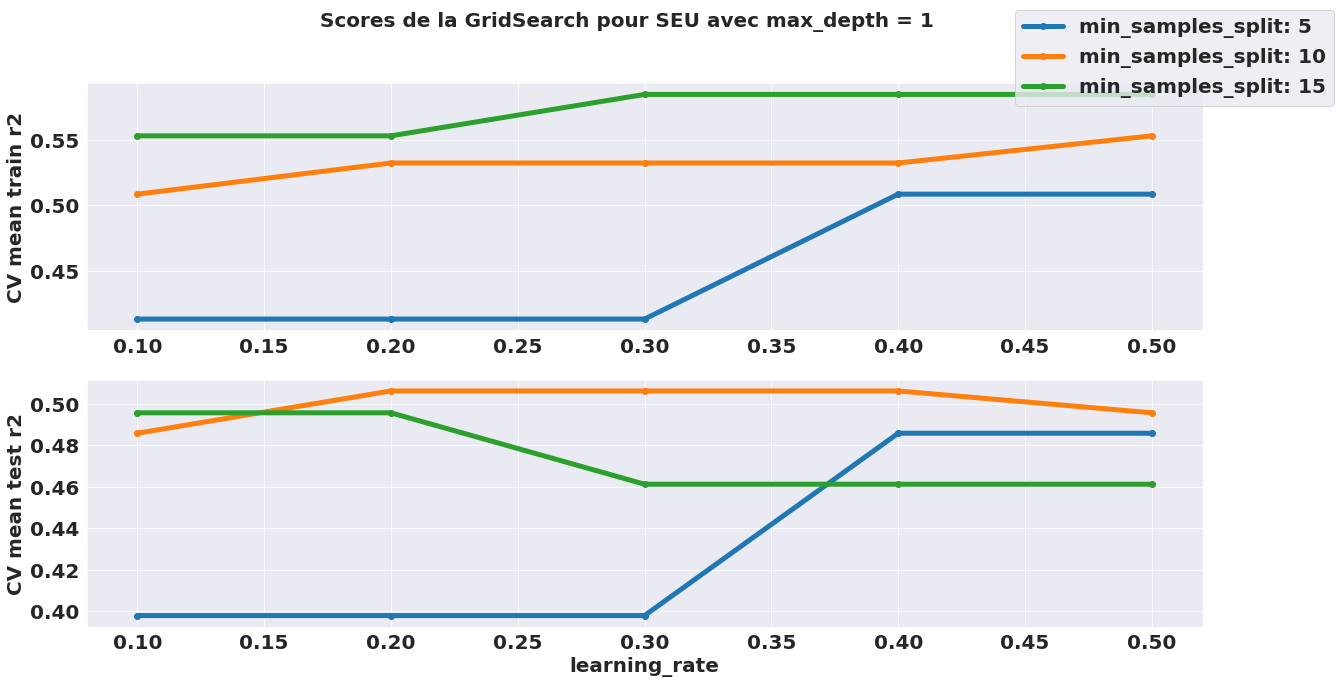

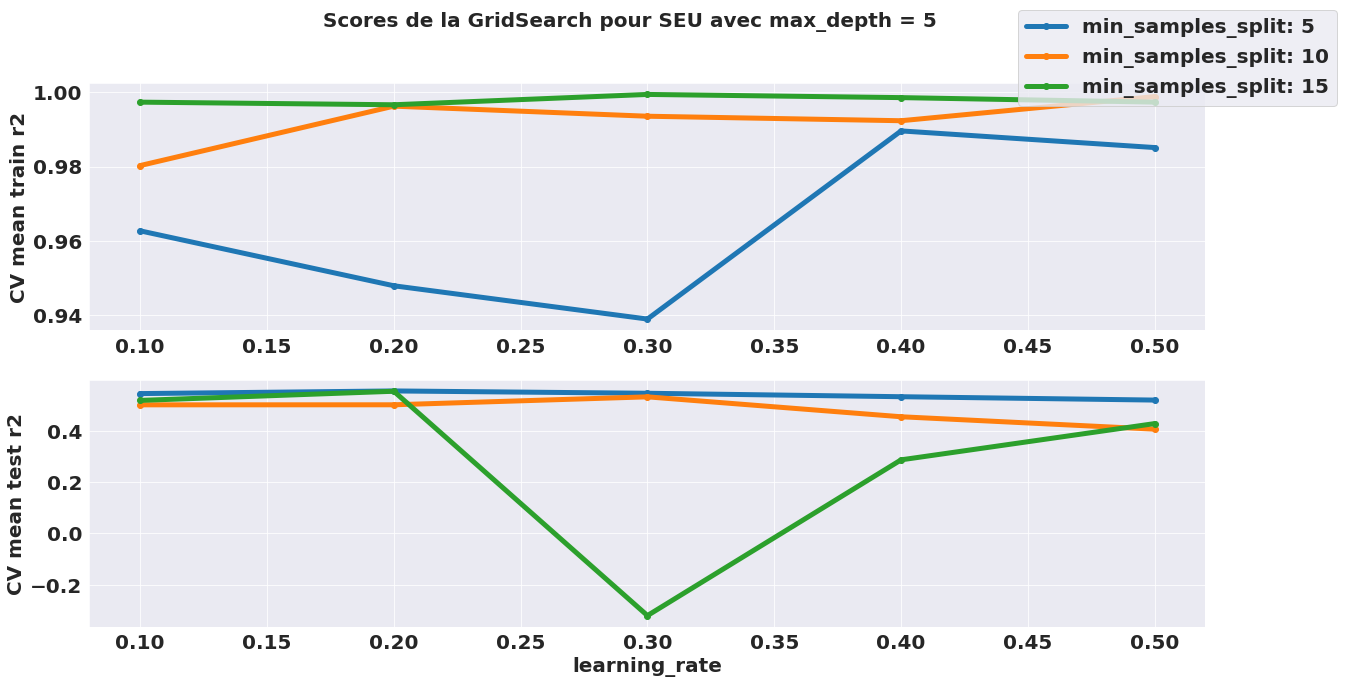

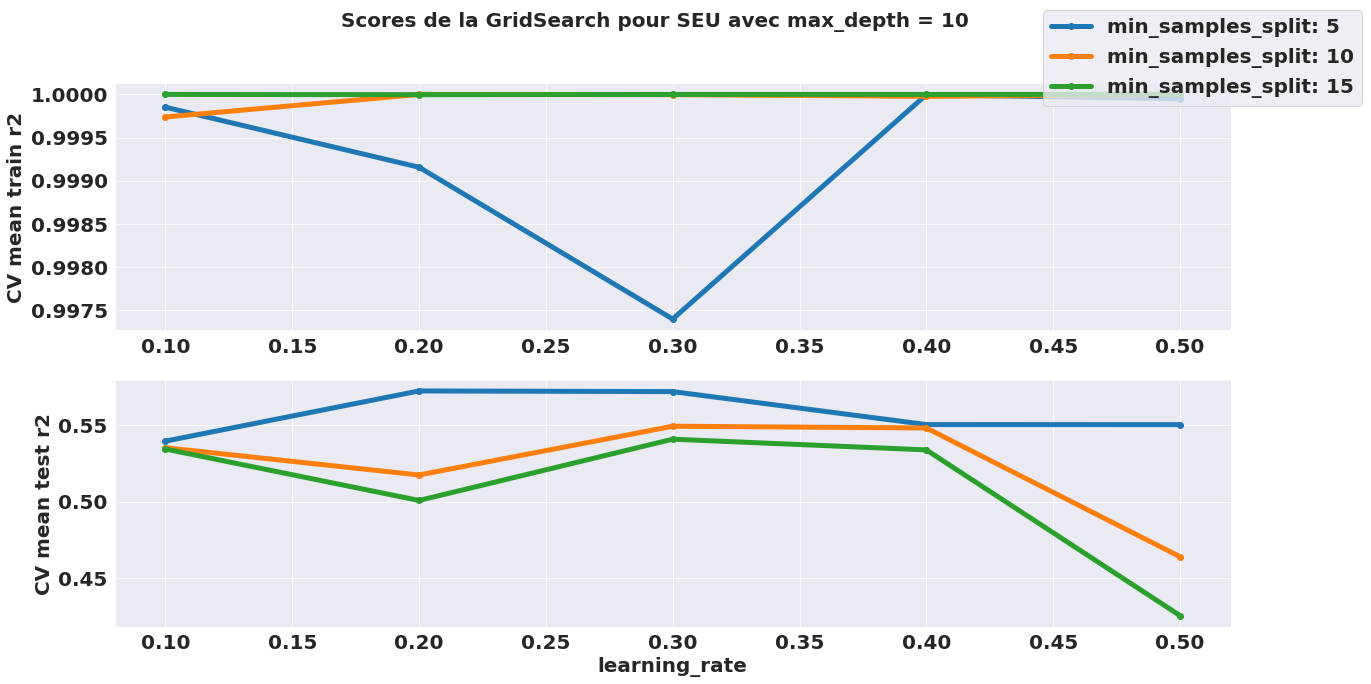

In [36]:
# Liste des paramètres "dynamiques"
name_param_dy = ['model__regressor__learning_rate',
                 'model__regressor__min_samples_split']

for p in np.arange(0,3,):
    # Paramètre "intermédiare"
    s = 'model__regressor__max_depth'
    v = grid_params_gbr[s][p]
    
    # Dictionnaire des paramètres "statiques"
    dict_param_st = {s : v ,
                    'model__regressor__min_samples_leaf' : 1,
                    }
    
    plot_reduced_grid(seu_gbr_spl.cv_results_,
                      'SEU',
                    dict_param_st,
                    name_param_dy,
                    'r2',
                    s + ' = ' + str(v))

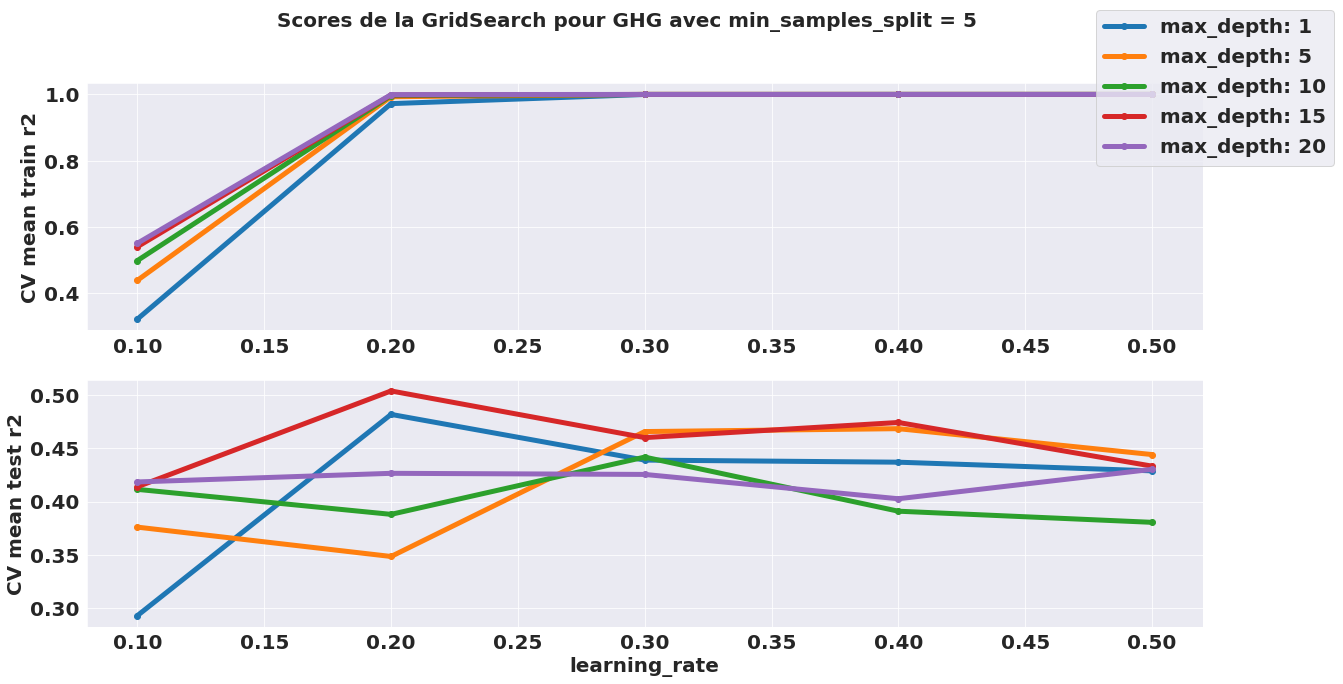

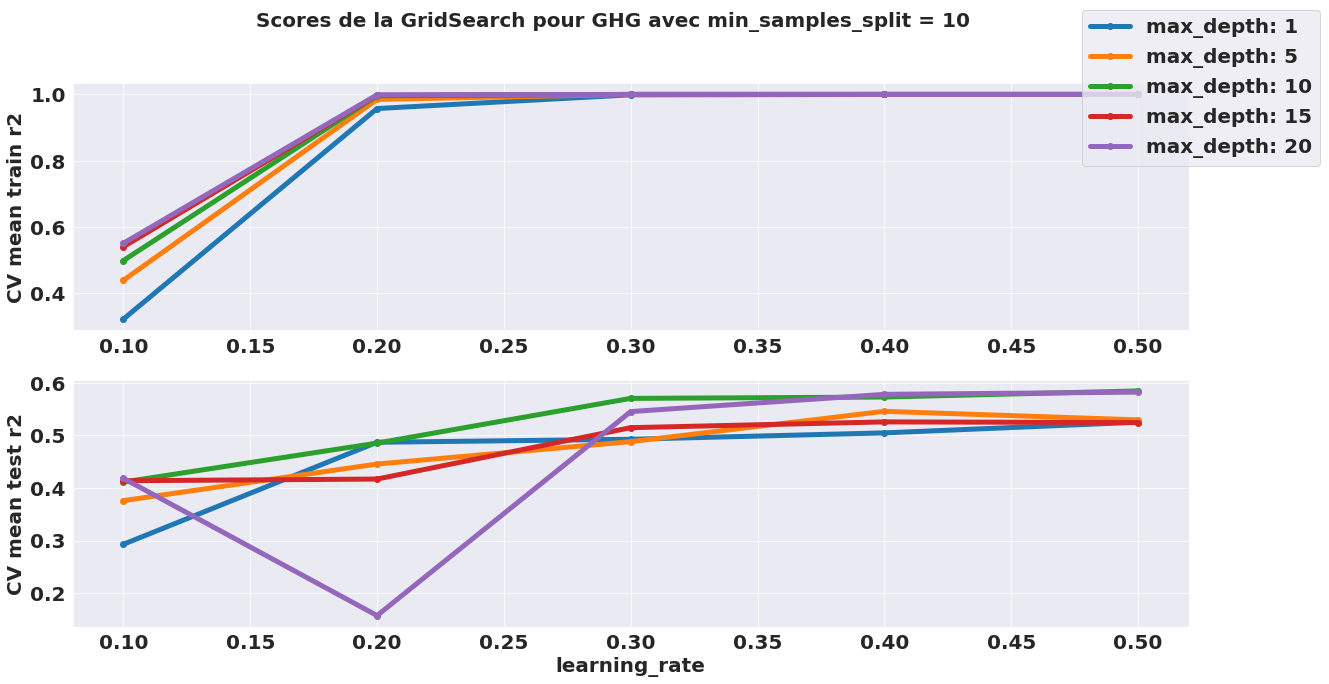

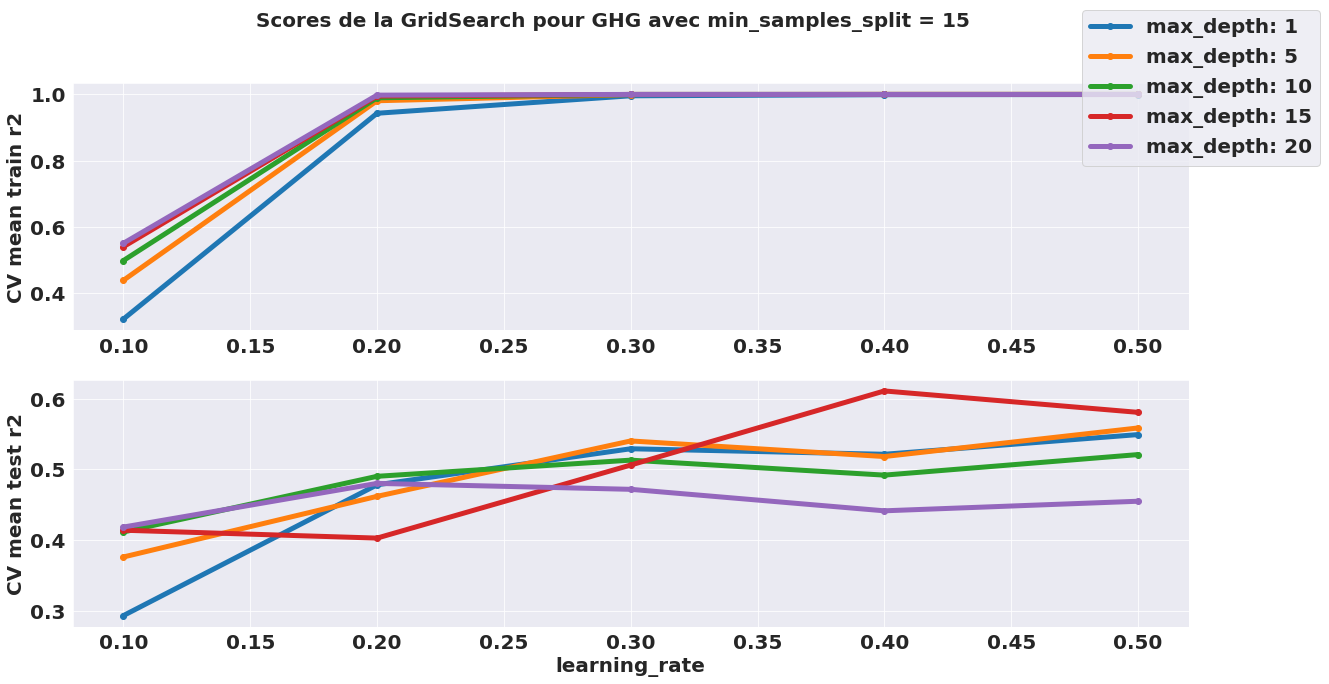

In [37]:
# Liste des paramètres "dynamiques"
name_param_dy = ['model__regressor__learning_rate',
                 'model__regressor__max_depth']

for p in np.arange(0,3,):
    # Paramètre "intermédiare"
    s = 'model__regressor__min_samples_split'
    v = grid_params_gbr[s][p]
    
    # Dictionnaire des paramètres "statiques"
    dict_param_st = {s : v ,
                    'model__regressor__min_samples_leaf' : 1,
                    }
    
    plot_reduced_grid(ghg_gbr_spl.cv_results_,
                      'GHG',
                    dict_param_st,
                    name_param_dy,
                    'r2',
                    s + ' = ' + str(v))

#### Temps d'entraînement

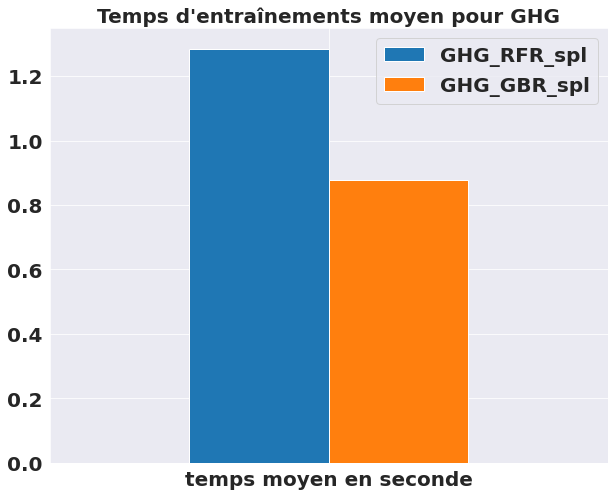

In [38]:
temps_moyen_GHG = {'GHG_RFR_spl': {'temps moyen en seconde': np.mean(ghg_rfr_spl.cv_results_['mean_fit_time'])},
                   'GHG_GBR_spl': {'temps moyen en seconde': np.mean(ghg_gbr_spl.cv_results_['mean_fit_time'])}}

pd.DataFrame.from_dict(temps_moyen_GHG).plot.bar(figsize=(10,8), rot=0)
plt.title("Temps d'entraînements moyen pour GHG", fontdict=font_style)
plt.show()

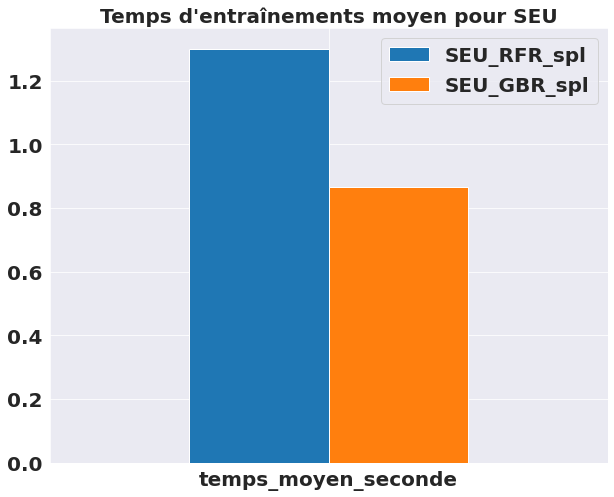

In [39]:
temps_moyen_SEU = {'SEU_RFR_spl': {'temps_moyen_seconde': np.mean(seu_rfr_spl.cv_results_['mean_fit_time'])},
                   'SEU_GBR_spl': {'temps_moyen_seconde': np.mean(seu_gbr_spl.cv_results_['mean_fit_time'])}}

pd.DataFrame.from_dict(temps_moyen_SEU).plot.bar(figsize=(10,8), rot=0)
plt.title("Temps d'entraînements moyen pour SEU", fontdict=font_style)
plt.show()

Malgré des erreurs plus élevés, le modèle `GradientBoostingRegressor` présente un avantage conséquent en raison d'un temps de calcul largement inférieur comparé au `RandomForestRegressor`.
Pour la suite, nous allons donc garder les deux modèles basés sur les arbres de décision pour évaluer l'intérêt de la variable **ESS**.

# <font color="#00afe6" id=section_4> 4. Évaluation de l'ESS </font>

On ajoute la variable `ENERGYSTARScore` à la liste des variables quantitatives à standardiser.

In [40]:
num_var.append('ENERGYSTARScore')

In [41]:
X_ess = df[num_var + cat_var] #  

# Filtrage des données ayant un Energy Star Score renseigné
X_ess = X_ess[~X_ess.isna().any(axis=1)]
y_ess = y_spl[y_spl.index.isin(list(X_ess.index))]

from sklearn.model_selection import train_test_split
X_train_ess, X_test_ess, y_train_ess, y_test_ess = train_test_split(X_ess, 
                                                                    y_ess, 
                                                                    test_size    = 0.2, 
                                                                    random_state = 0)

#
SEU_train_ess = y_train_ess[var_target[0]]
SEU_test_ess  = y_test_ess[var_target[0]]
#
GHG_train_ess = y_train_ess[var_target[1]]
GHG_test_ess  = y_test_ess[var_target[1]]
#

In [42]:
# Fonction pour récupérer les best_params_ dans un nouveau dictionnaire
def recup_best_params(cv_best_params):
    recup_params = {}
    for name, value in cv_best_params.items():
        recup_params[name] = [value]
    return recup_params

## Random Forest Regressor

In [43]:
#
seu_params_rfr_ess = recup_best_params(seu_rfr_spl.best_params_)
ghg_params_rfr_ess = recup_best_params(ghg_rfr_spl.best_params_)
# 
ghg_rfr_ess = gridsearch_construction(pipeline_rfr, seu_params_rfr_ess,5)
seu_rfr_ess = gridsearch_construction(pipeline_rfr, ghg_params_rfr_ess,5)

# Entrainement
##
start_time = time.time()
#
seu_rfr_ess.fit(X_train_ess, SEU_train_ess)
print("Temps d'execution pour SEU : {:.3} s.".format((time.time() - start_time)))
##
start_time = time.time()
#
ghg_rfr_ess.fit(X_train_ess, GHG_train_ess)
print("Temps d'execution pour GHG : {:.3} s.".format((time.time() - start_time)))
#
# Prédiction sur le test 
SEU_rfr_test_ess = seu_rfr_ess.predict(X_test_ess)
# 
GHG_rfr_test_ess = ghg_rfr_ess.predict(X_test_ess)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Temps d'execution pour SEU : 0.629 s.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Temps d'execution pour GHG : 0.639 s.


## Gradient Boosting

In [44]:
seu_params_gbr_ess = recup_best_params(seu_gbr_spl.best_params_)
ghg_params_gbr_ess = recup_best_params(ghg_gbr_spl.best_params_)
# 
seu_gbr_ess = gridsearch_construction(pipeline_gbr, seu_params_gbr_ess,5)
ghg_gbr_ess = gridsearch_construction(pipeline_gbr, ghg_params_gbr_ess,5)

# Entrainement
##
start_time = time.time()
#
seu_gbr_ess.fit(X_train_ess, SEU_train_ess)
print("Temps d'execution pour SEU : {:.3} s.".format((time.time() - start_time)))
##
start_time = time.time()
#
ghg_gbr_ess.fit(X_train_ess, GHG_train_ess)
#
print("Temps d'execution pour GHG : {:.3} s.".format((time.time() - start_time)))
#
# Prédiction sur le test set
SEU_gbr_test_ess = seu_gbr_ess.predict(X_test_ess)
# 
GHG_gbr_test_ess = ghg_gbr_ess.predict(X_test_ess)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Temps d'execution pour SEU : 1.2 s.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Temps d'execution pour GHG : 1.53 s.


### Résultats

In [45]:
SEU_metrics_ess = model_metrics([[SEU_test_ess, SEU_rfr_test_ess, 'SEU_RFR_ess'],
                                 [SEU_test_ess, SEU_gbr_test_ess, 'SEU_GBR_ess']])

SEU_metrics_all = pd.concat([SEU_metrics_spl[['SEU_RFR_spl', 'SEU_GBR_spl']], SEU_metrics_ess], axis=1)

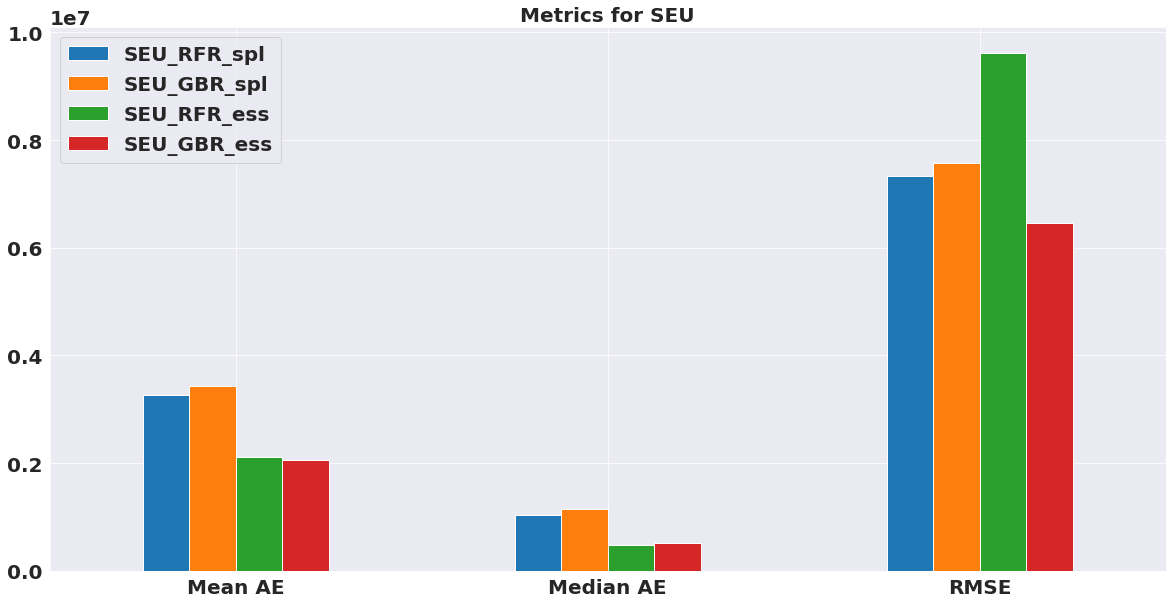

In [46]:
ax = SEU_metrics_all.plot.bar(figsize=(20,10), rot=0)
ax.legend(loc='upper left')
plt.title('Metrics for SEU', fontdict=font_style)
plt.show()

In [47]:
GHG_metrics_ess  = model_metrics([[GHG_test_ess, GHG_rfr_test_ess, 'GHG_RFR_ess'],
                                  [GHG_test_ess, GHG_gbr_test_ess, 'GHG_GBR_ess']])
#
GHG_metrics_all = pd.concat([GHG_metrics_spl[['GHG_RFR_spl', 'GHG_GBR_spl']], GHG_metrics_ess], axis=1)

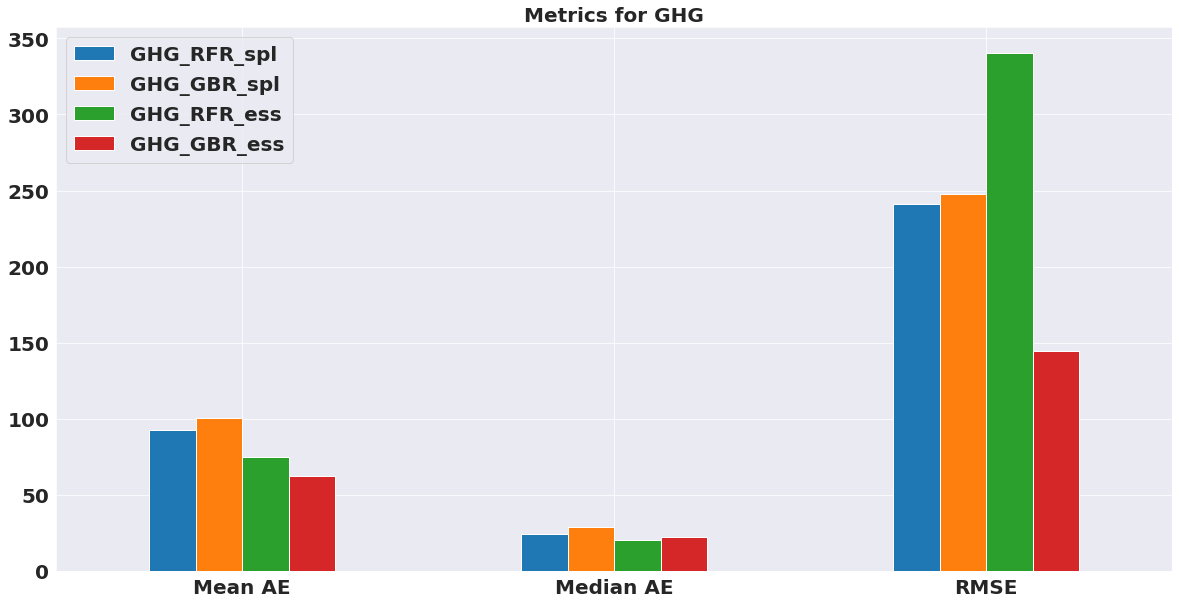

In [48]:
ax = GHG_metrics_all.plot.bar(figsize=(20,10), rot=0)
ax.legend(loc='upper left')
plt.title('Metrics for GHG', fontdict=font_style)
plt.show()

Contrairement à l'algorithme `RandomForestRegressor`, le score de l'algorithme `GradientBostingRegressor` se trouve très nettement amélioré en tenant compte de la variable **ESS**. Avec un temps d'entrainement moyen également inférieur. On peut conclure que ce dernier modèle révèle toute la pertinence de la variable *EnergyStarScore* pour la prédiction des consommations d'énergie et des émissions de gaz à effets de serre.

Ci-dessous, on montre la valeur du coefficient de détermination pour les modèles ensemblistes. On voit que le modèle `GradientBostingRegressor` capte plus de 85% de la variance des observations.

In [49]:
# Variance des modèles ensemblistes
variance_SEU = model_variance([[SEU_test_spl, SEU_rfr_test_spl, 'SEU_RFR_spl'], 
                               [SEU_test_ess, SEU_rfr_test_ess, 'SEU_RFR_ess'],
                               [SEU_test_spl, SEU_gbr_test_spl, 'SEU_GBR_spl'], 
                               [SEU_test_ess, SEU_gbr_test_ess, 'SEU_GBR_ess']])
variance_SEU

,SEU_RFR_spl,SEU_RFR_ess,SEU_GBR_spl,SEU_GBR_ess
r2score,0.643,0.717,0.618,0.872
expl_variance,0.664,0.721,0.635,0.873


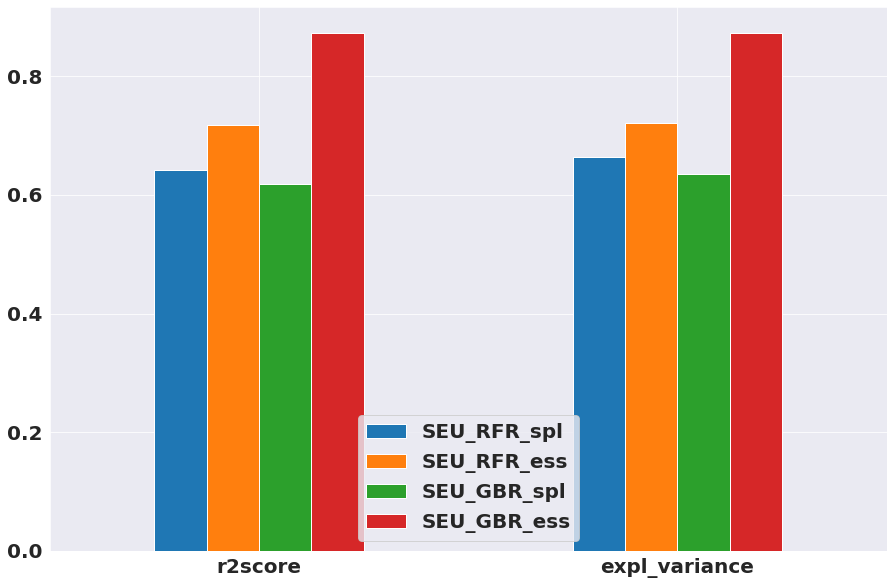

In [59]:
ax = variance_SEU.plot.bar(figsize=(15,10), rot=0)
plt.legend(loc='lower center')
plt.show()

In [51]:
# Variance des modèles ensemblistes
variance_GHG = model_variance([[GHG_test_spl, GHG_rfr_test_spl, 'GHG_RFR_spl'],
                               [GHG_test_ess, GHG_rfr_test_ess, 'GHG_RFR_ess'],
                               [GHG_test_spl, GHG_gbr_test_spl, 'GHG_GBR_spl'], 
                               [GHG_test_ess, GHG_gbr_test_ess, 'GHG_GBR_ess']])
variance_GHG

,GHG_RFR_spl,GHG_RFR_ess,GHG_GBR_spl,GHG_GBR_ess
r2score,0.505,0.633,0.477,0.934
expl_variance,0.531,0.638,0.496,0.934


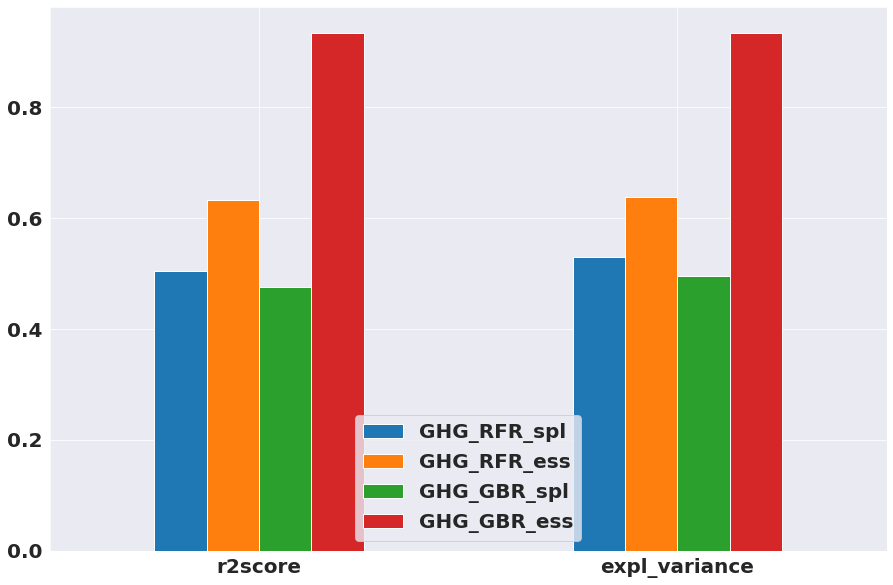

In [60]:
ax = variance_GHG.plot.bar(figsize=(15,10), rot=0)
plt.legend(loc='lower center')
plt.show()

Ci-dessous l'importance des différentes variables indépendantes de notre modélisation avec/sans la variable **ESS**. Selon la variable à prédire, cette dernière n'a pas le même effet sur les différentes *features*. 

In [53]:
def get_imp_features(cv_results,train_columns,name):
    model = cv_results.best_estimator_.named_steps.model.regressor_
    
    imp_features = pd.DataFrame(model.feature_importances_,
                                columns=[name],
                               index=train_columns)
    return imp_features

imp_rfr_S_spl = get_imp_features(seu_rfr_spl, X_train_spl.columns, 'rfr_spl')
imp_gbr_S_spl = get_imp_features(seu_gbr_spl, X_train_spl.columns, 'gbr_spl')

imp_rfr_G_spl = get_imp_features(ghg_rfr_spl, X_train_spl.columns, 'rfr_spl')
imp_gbr_G_spl = get_imp_features(ghg_gbr_spl, X_train_spl.columns, 'gbr_spl')

imp_rfr_S_ess = get_imp_features(seu_rfr_ess, X_train_ess.columns, 'rfr_ess')
imp_gbr_S_ess = get_imp_features(seu_gbr_ess, X_train_ess.columns, 'gbr_ess')

imp_rfr_G_ess = get_imp_features(ghg_rfr_ess, X_train_ess.columns, 'rfr_ess')
imp_gbr_G_ess = get_imp_features(ghg_gbr_ess, X_train_ess.columns, 'gbr_ess')

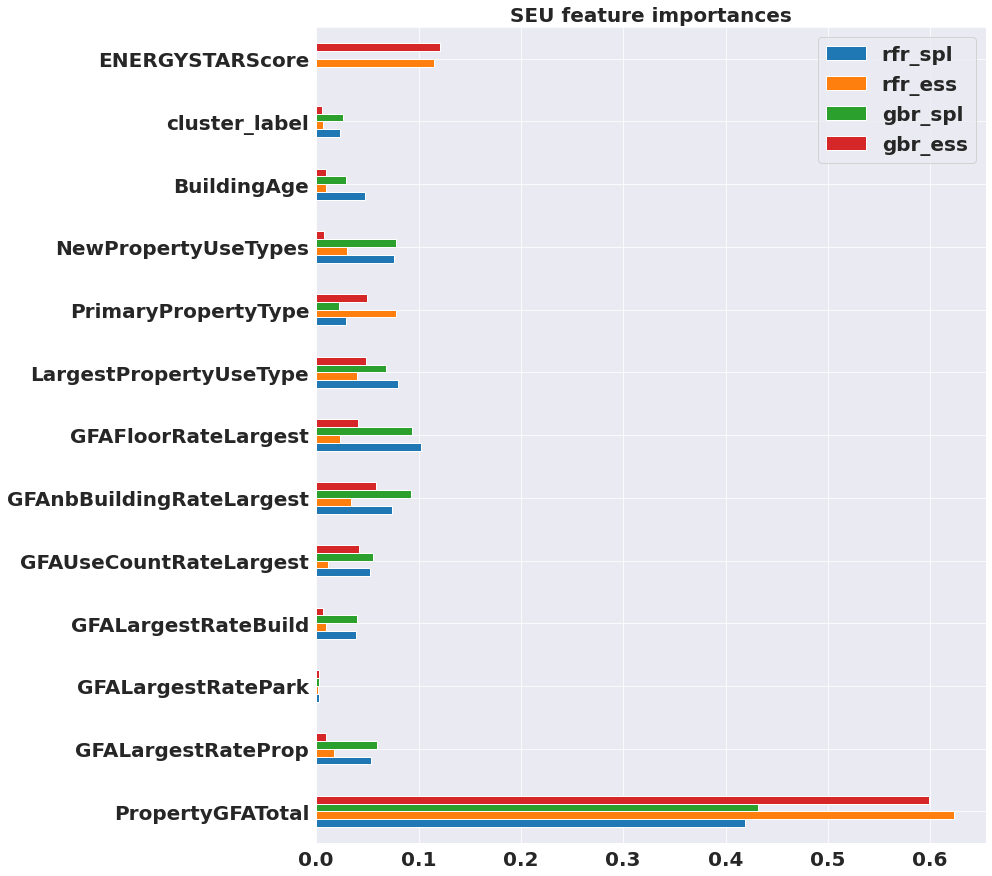

In [54]:
ax = pd.concat([imp_rfr_S_spl, imp_rfr_S_ess, imp_gbr_S_spl, imp_gbr_S_ess],axis=1).plot.barh(figsize=(12,15))
plt.title('SEU feature importances', fontdict=font_style)
plt.show()

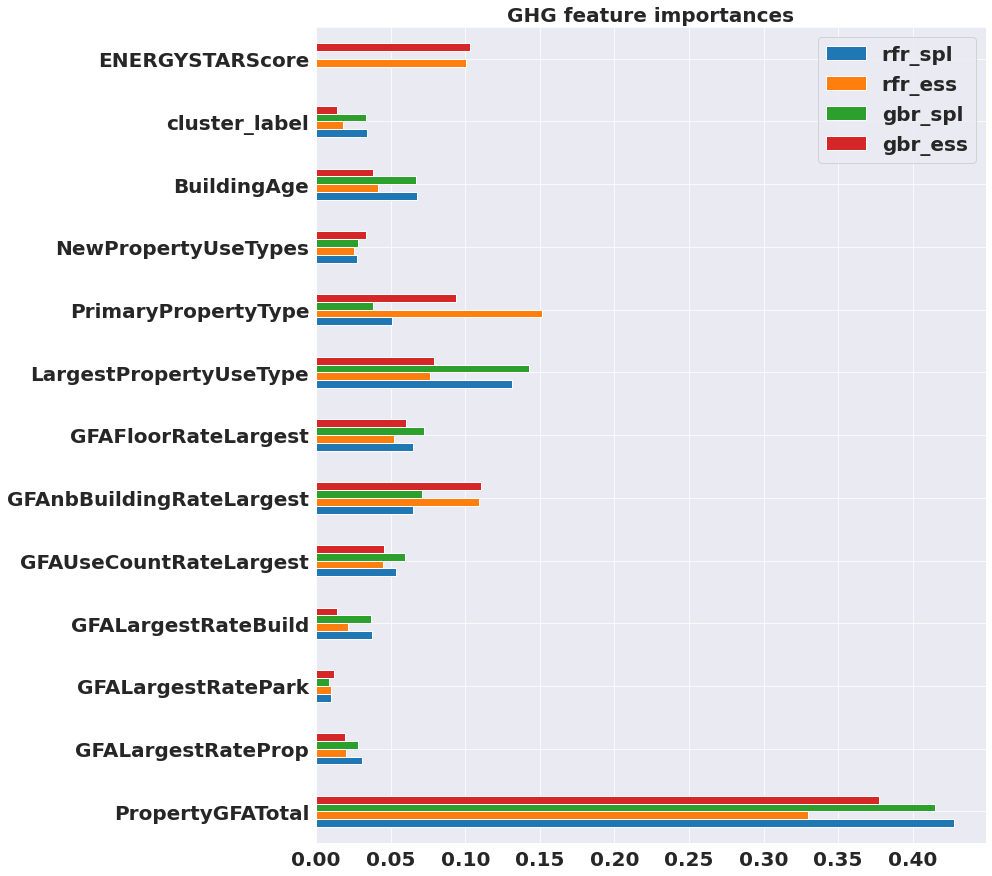

In [55]:
ax = pd.concat([imp_rfr_G_spl, imp_rfr_G_ess, imp_gbr_G_spl, imp_gbr_G_ess],axis=1).plot.barh(figsize=(12,15))
plt.title('GHG feature importances', fontdict=font_style)
plt.show()

Pour avoir une prédiction avec un meilleur score, il serait certainement très intéressant d'utiliser pour chaque variable à prédire une jeu de variables indépendantes différent. 
On pourrait ainsi mieux appréhender les consommations et émissions des bâtiments en utilisant uniquement certaines des informations générales du dataset original.